In [1]:
import os
thread_limit = 16

# Limit threads BEFORE importing numpy
os.environ["OMP_NUM_THREADS"] = str(thread_limit)
os.environ["OPENBLAS_NUM_THREADS"] = str(thread_limit)
os.environ["MKL_NUM_THREADS"] = str(thread_limit)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread_limit)
os.environ["NUMEXPR_NUM_THREADS"] = str(thread_limit)

In [2]:
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import scanpy as sc
from matplotlib_venn import venn2
import scrublet as scr
import pandas as pd
from pybiomart import Server
from upsetty import Upset
from tqdm import tqdm
from scipy import sparse
import multiprocessing

In [3]:
%matplotlib inline

In [4]:
outdir = "/mnt/data1/10XvParse/Analysis_2/"
fasta_folder = "FASTA/Processed/"
sample_folder = "FASTA/Sampled/"
sra_folder = "SRA/"
tmp_folder = "tmp/"

In [5]:
names = ['10x', 'polyT', 'randO', 'parse']

In [6]:
min_counts = 187061165

# Downsample

In [7]:
def subSample(name):
    path = outdir + fasta_folder + name
    out = outdir + sample_folder + name
    !seqtk sample -s 42 {path+"_1.fastq.gz"} {min_counts} | pigz -p 8 > {out+"_1.fastq.gz"}
    print("Starting",name,"second read subsampling")
    !seqtk sample -s 42 {path+"_2.fastq.gz"} {min_counts} | pigz -p 8 > {out+"_2.fastq.gz"}
    print("Finished",name)

with multiprocessing.Pool(processes=1) as pool:
    print(pool.map(subSample,names))
    print("done")

KeyboardInterrupt: 

In [12]:
def align(iter):
    name = iter[0]
    tech = iter[1]
    path = outdir + sample_folder + name
    out = outdir + "sample_" + name + "_out"

    if name == 'parse':
        !kb count --overwrite --h5ad -r parse_extraction/replace.txt \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fastq.gz"} {path+"_2.fastq.gz"}
    else:
        !kb count --overwrite --h5ad \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fastq.gz"} {path+"_2.fastq.gz"}

    print("Finished",name)

with multiprocessing.Pool(processes=2) as pool:
    iter = zip(names,
               ['10XV3', "SPLIT-SEQ", "SPLIT-SEQ", "SPLIT-SEQ"])
    print(pool.map(align,iter))
    print("done")

[2025-08-04 13:34:01,019]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_10x_out from
[2025-08-04 13:34:01,020]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_1.fastq.gz
[2025-08-04 13:34:01,020]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_2.fastq.gz
[2025-08-04 13:34:01,020]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_polyT_out from
[2025-08-04 13:34:01,020]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_1.fastq.gz
[2025-08-04 13:34:01,020]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_2.fastq.gz
[2025-08-04 13:50:21,789]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/sample_10x_out/output.bus to /mnt/data1/10XvParse/Analysis_2/sample_10x_out/tmp/output.s.bus
[2025-08-04 13:50:49,025]    INFO [count] On-list not provided
[2025-08-04 13:50:49,02

In [7]:
datasets = []
for name in names:
    if name == 'parse':
        file = outdir + "sample_" + name + "_out/counts_unfiltered_modified/adata.h5ad"
    else:
        file = outdir + "sample_" + name + "_out/counts_unfiltered/adata.h5ad"
    data = anndata.read_h5ad(file)
    datasets.append(data)

In [8]:
# Filter data to ensure no zero counts/genes/cells
for data, name, title in zip(datasets,
                            ['10x', 'polyT', 'randO', 'parse'],
                            ["10x Genomics", "Parse 3\'", "Parse Random Oligo", "Parse"]):
    
    data.var["gene_id"] = data.var.index.tolist()

    gene_names = []
    dir = outdir + "sample_" + name + "_out/counts_unfiltered/"

    with open(dir + 'cells_x_genes.genes.names.txt', 'r') as file:
        for line in file:
            gene_names.append(line.strip())

    data.var_names = gene_names

    data.uns['name'] = name
    data.uns['title'] = title
    sc.pp.filter_cells(data, min_genes=1)
    sc.pp.filter_genes(data, min_cells=1)
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum()

In [9]:
aligned_counts = [data.X.sum() / min_counts for data in datasets]
unaligned_counts = [(min_counts - data.X.sum()) / min_counts for data in datasets]

# Population Upsampling Estimation

In [25]:
# Find the projected number of unique transcripts to be found using each method if sampling were to continue
# Using PreSeq (Daley and Smith 2013) based off of the recommendation from this paper: https://www.biorxiv.org/content/10.1101/2024.10.09.615408v1.full.pdf

for data in datasets:
    filename = f"counts/{data.uns['name']}_counts.txt"
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(filename, "w") as f:
        counts = data.X.sum(axis=0).A1
        for count in counts:
            f.write(f"{int(count)}\n")
    !preseq lc_extrap -o {fileout} -V {filename}
    with open(fileout, "r") as f:
        rows = []
        first_line = f.readline()
        for line in f:
            rows.append(list(map(float,line.split())))
    data.uns['pred_upsample'] = np.array(rows)

^C


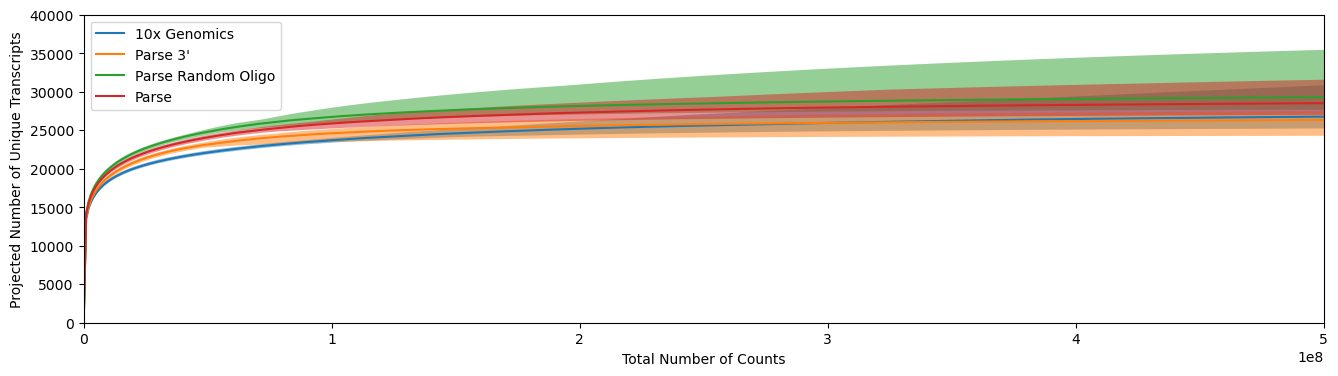

In [33]:
plt.figure(figsize=(16, 4))
for data in datasets:
    pred = data.uns['pred_upsample']
    plt.plot(pred[:, 0], pred[:, 1], label=data.uns['title'])
    plt.fill_between(pred[:, 0], pred[:,2], pred[:,3], alpha=0.5)

plt.legend(loc='upper left')
plt.xlim(0,5e8)
plt.ylim(0, 4e4)
plt.xlabel('Total Number of Counts')
plt.ylabel('Projected Number of Unique Transcripts')
plt.show()

# Doublet Detection Comparison

In [10]:
def doublet_detection(data):
    scrub = scr.Scrublet(data.X, random_state = 42)
    data.obs['doublet_score'], data.obs['predicted_doublet'] = scrub.scrub_doublets()
    return scrub, data

with multiprocessing.Pool(processes=2) as pool:
    doublet_results = pool.map(doublet_detection, datasets)
    print("done")

Preprocessing...
Preprocessing...
Simulating doublets...


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 46.7%
Estimated detectable doublet fraction = 68.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 68.3%
Elapsed time: 929.3 seconds
Preprocessing...


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.06
Detected doublet rate = 55.9%
Estimated detectable doublet fraction = 72.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 76.7%
Elapsed time: 845.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 45.7%
Estimated detectable doublet fraction = 66.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 68.7%
Elapsed time: 1071.8 seconds
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 4.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.1%
Elapsed time: 5849.0 seconds
done


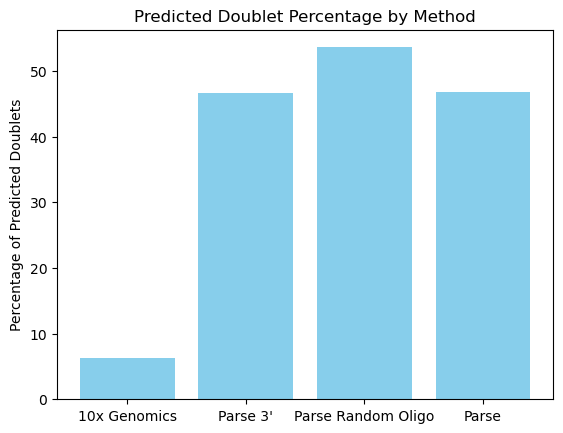

In [15]:
percent_doublets = []
doublet_thresh = [0.15, 0.07, 0.07, 0.07]

for (scrub, data), thresh in zip(doublet_results, doublet_thresh):
    percent_doublets.append((data.obs['doublet_score'] > thresh).sum() / data.shape[0] * 100)

plt.bar([data.uns['title'] for data in datasets], percent_doublets, color='skyblue')
plt.ylabel('Percentage of Predicted Doublets')
plt.title('Predicted Doublet Percentage by Method')

plt.show()

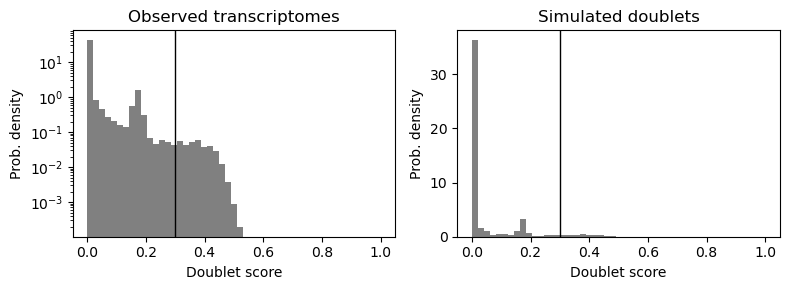

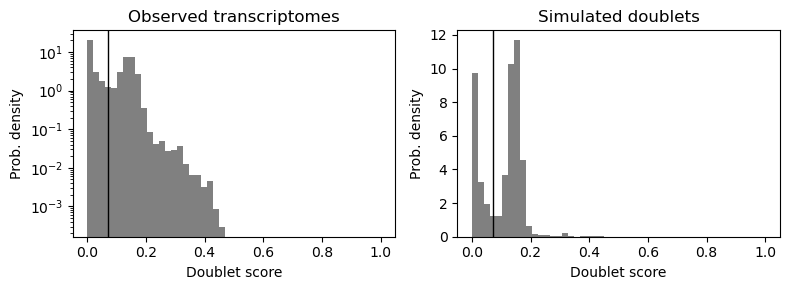

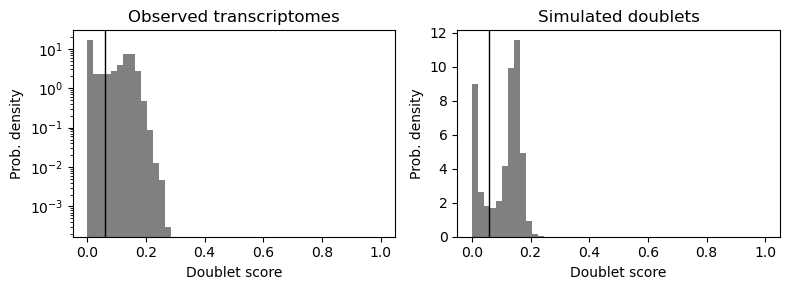

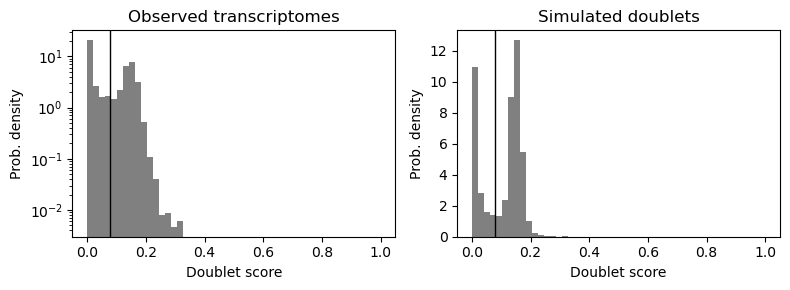

In [12]:
for scrub, data in doublet_results:
    scrub.plot_histogram()

In [22]:
for scrub, data in doublet_results:
    print("Starting: " + data.uns['title'])
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

Starting: 10x Genomics


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

# Quality Control Comparison

In [10]:
# Scatter plot of genes detected vs. UMI counts
def scatter_reads(ax, data):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title'] + " Reads")

# Knee plot with threshold axes
def knee_plot(ax, data, cutoff = 20):
    knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {data.uns['title']}")
    sc.pp.filter_cells(data, min_counts=knee[num_cells])

# Scatter plot for mitochondrial percentage
def mito_scatter(ax, data):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(data.uns['title'])
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

# Generates violin plots of selected metadata
def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], stripplot=False, show=False)
        ax_col[i].set_xticks([])

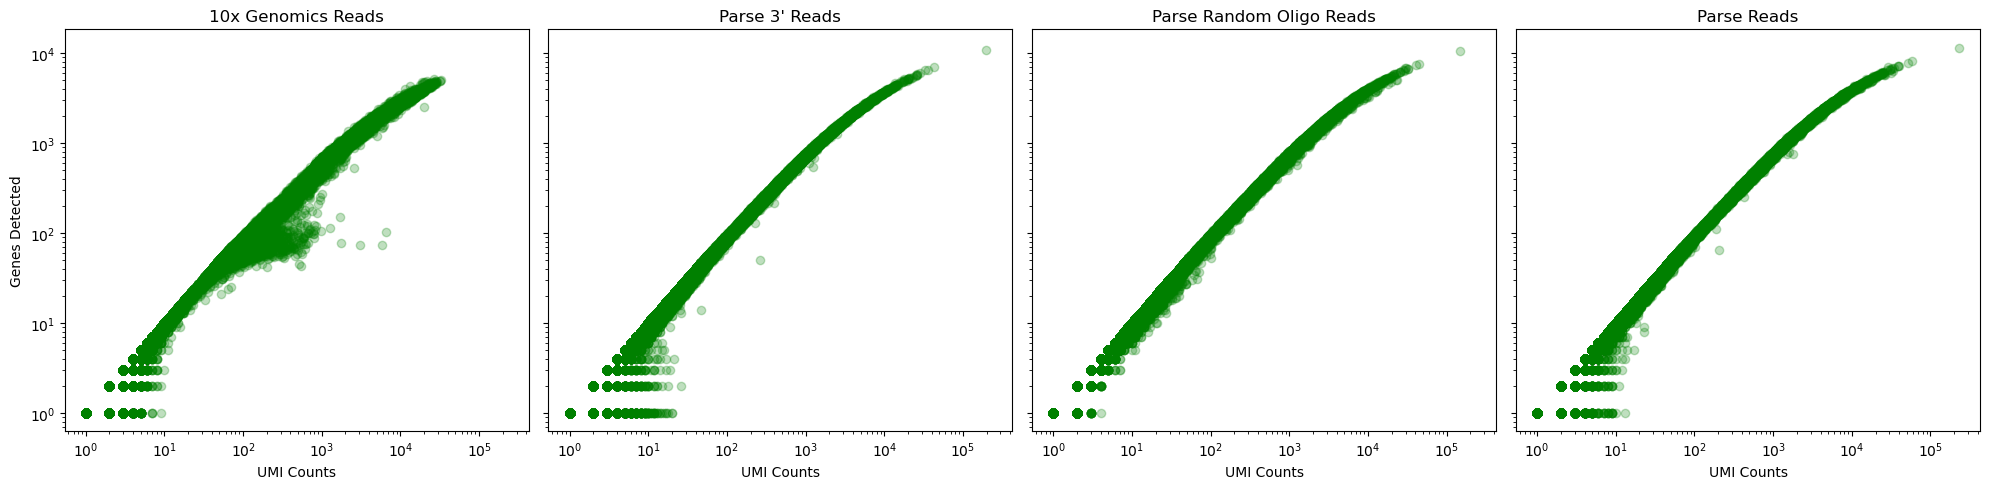

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)

for i, data in enumerate(datasets):
    scatter_reads(ax[i], data)

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()

In [12]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

lnc_result = dataset.query(attributes=[
   'ensembl_gene_id_version'
], filters={'transcript_biotype': ['lncRNA']})

# Clean column names
lnc_result.columns = ['gene_id']

In [13]:
# Query Ensembl for protein coding genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

pc_result = dataset.query(attributes=[
   'ensembl_gene_id_version'
], filters={'transcript_biotype': ['protein_coding']})

# Clean column names
pc_result.columns = ['gene_id']

In [14]:
# Query Ensembl for Biotype
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

biotype_result = dataset.query(attributes=[
   'external_gene_name',
   'ensembl_gene_id_version', 
   'transcript_biotype'
])

# Clean column names
biotype_result.columns = ['gene_name','gene_id', 'biotype']

In [15]:
# Query Ensembl for transcript lengths
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

length_result = dataset.query(attributes=[
    'external_gene_name',
    'ensembl_gene_id_version', 
    'ensembl_exon_id',
    'exon_chrom_start',
    'exon_chrom_end'])

# Clean column names
length_result.columns = ['gene_name','gene_id', 'exon_id', 'exon_start', 'exon_end']
l_df = length_result.copy()

In [16]:
# Drop duplicates to avoid counting shared exons multiple times
l_df.drop_duplicates(subset=['gene_name','gene_id', 'exon_start', 'exon_end'], inplace=True)

# Compute exon lengths
l_df['exon_length'] = l_df['exon_end'] - l_df['exon_start'] + 1

# Sum exon lengths per gene
gene_lengths = l_df.groupby(['gene_id','gene_name'])['exon_length'].sum().reset_index()
gene_lengths.rename(columns={'exon_length': 'gene_length'}, inplace=True)

In [17]:
# Query Ensembl for gc content
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

gc_result = dataset.query(attributes=[
    'ensembl_transcript_id_version',
    'external_gene_name',
    'ensembl_gene_id_version',
    'percentage_gene_gc_content'])

# Clean column names
gc_result.columns = ['transcript_id', 'gene_name', 'gene_id', 'gc_content']
gc_df = gc_result.copy()

In [18]:
# Drop duplicates to avoid counting shared exons multiple times
gc_df.drop_duplicates(subset=['gene_name','gene_id','transcript_id','gc_content'], inplace=True)

# average gc_content per trancript
gc_content = gc_df.groupby(['gene_id','gene_name'])['gc_content'].mean().reset_index()

In [19]:
def add_cell_metrics(data):
    lncRNA_genes = set(data.var["gene_id"].tolist()).intersection(set(lnc_result['gene_id'].tolist()))
    pc_genes = set(data.var["gene_id"].tolist()).intersection(set(pc_result['gene_id'].tolist()))
    
    # Identify lncRNA genes
    data.var["is_lnc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

    # Identify protein-coding genes
    data.var["is_pc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(pc_genes)), ["is_pc"]] = True

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    data.var["is_mito"] = data.var_names.str.startswith("mt")
    # ribosomal genes
    data.var["is_ribo"] = data.var_names.str.startswith(("Rps", "Rpl"))

    pc_counts = data[:, data.var['is_pc']].X.sum(axis=1)
    mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
    ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
    lnc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

    # Calculate total counts per cell
    total_counts = data.X.sum(axis=1)

    # Calculate percent mitochondrial and ribosomal gene expression per cell
    data.obs['percent_pc'] = np.array(pc_counts / total_counts * 100).flatten()
    data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
    data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
    data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

    # Calculate gene lengths based on exon lengths
    index = data.var.index
    data.var = data.var.merge(gene_lengths[['gene_id','gene_length']],how='left',on='gene_id').fillna(1)
    data.var = data.var.merge(gc_content[['gene_id','gc_content']],how='left',on='gene_id').fillna(0)
    data.var.set_index(index,inplace=True)

In [20]:
for data in datasets:
    add_cell_metrics(data)

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Tra

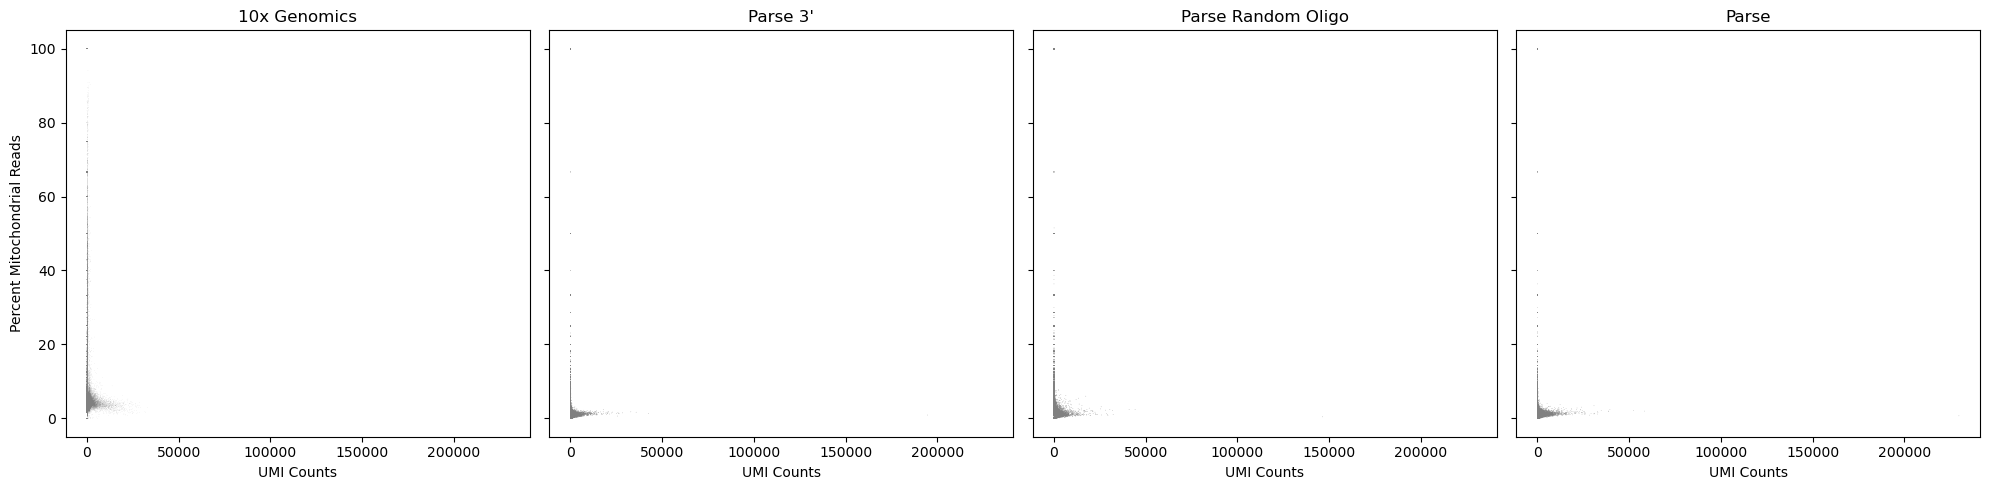

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
for i, data in enumerate(datasets):
    mito_scatter(ax[i], data)

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

13,257 cells passed the 298 UMI threshold for 10x Genomics
13,256 cells passed the 302 UMI threshold for Parse 3'
13,253 cells passed the 271 UMI threshold for Parse Random Oligo
11,719 cells passed the 482 UMI threshold for Parse


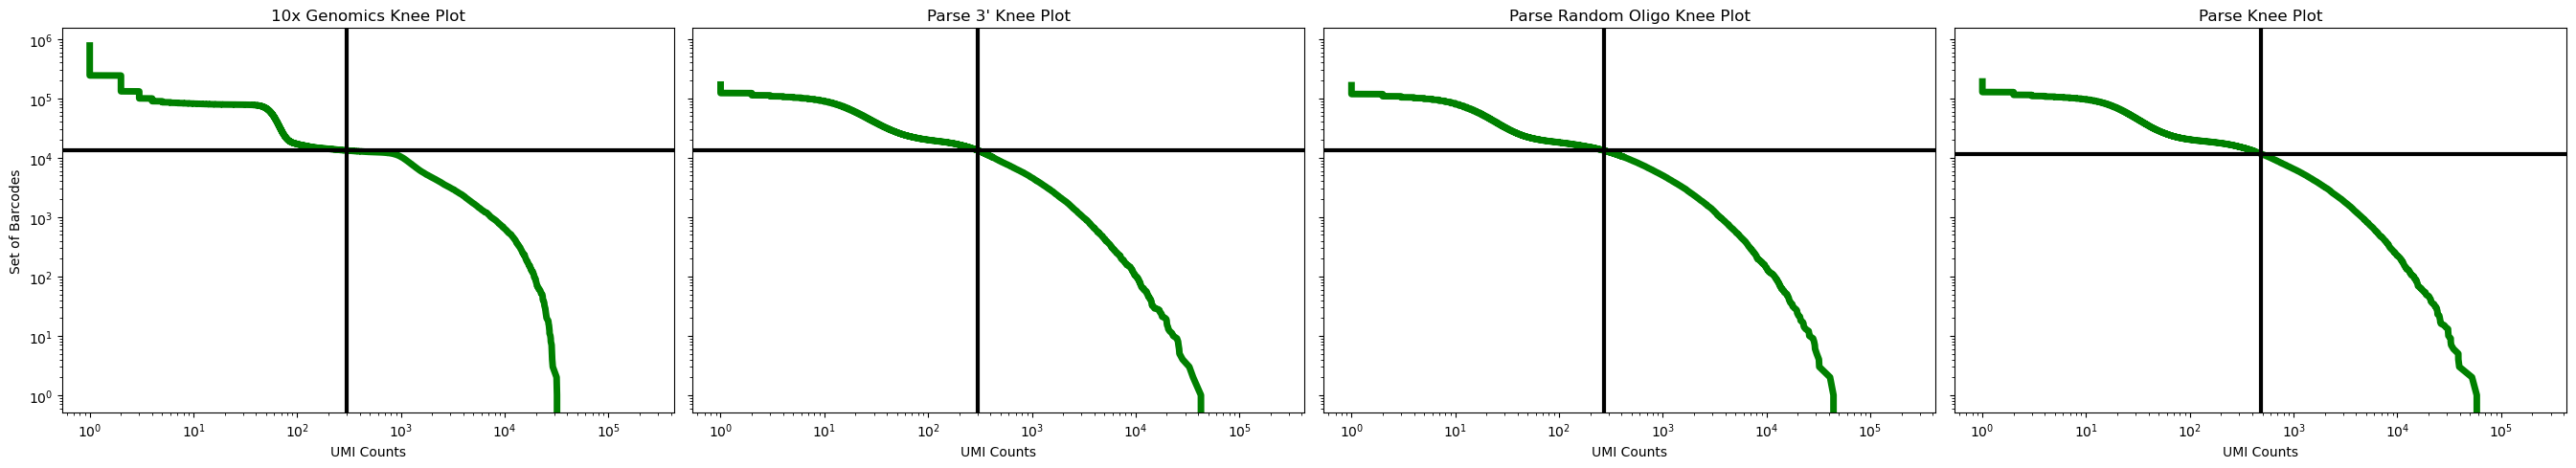

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)

cutoffs = [298, 302, 271, 482]

for i, (data, cutoff) in enumerate(zip(datasets, cutoffs)):
    knee_plot(ax[i], data, cutoff=cutoff)

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

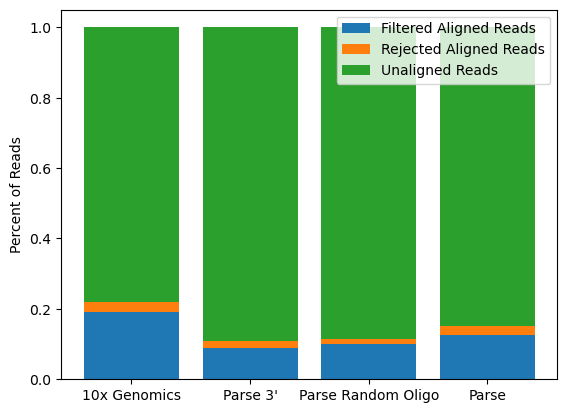

In [24]:
labels = [data.uns['title'] for data in datasets]
rejected_counts = aligned_counts - np.array([data.X.sum() / min_counts for data in datasets])
kept_counts = [data.X.sum() / min_counts for data in datasets]

plt.bar(labels, kept_counts, label = "Filtered Aligned Reads")
plt.bar(labels, rejected_counts, bottom=kept_counts, label = "Rejected Aligned Reads")
plt.bar(labels, unaligned_counts, bottom=rejected_counts+kept_counts, label = "Unaligned Reads")
plt.ylabel('Percent of Reads')
plt.legend()

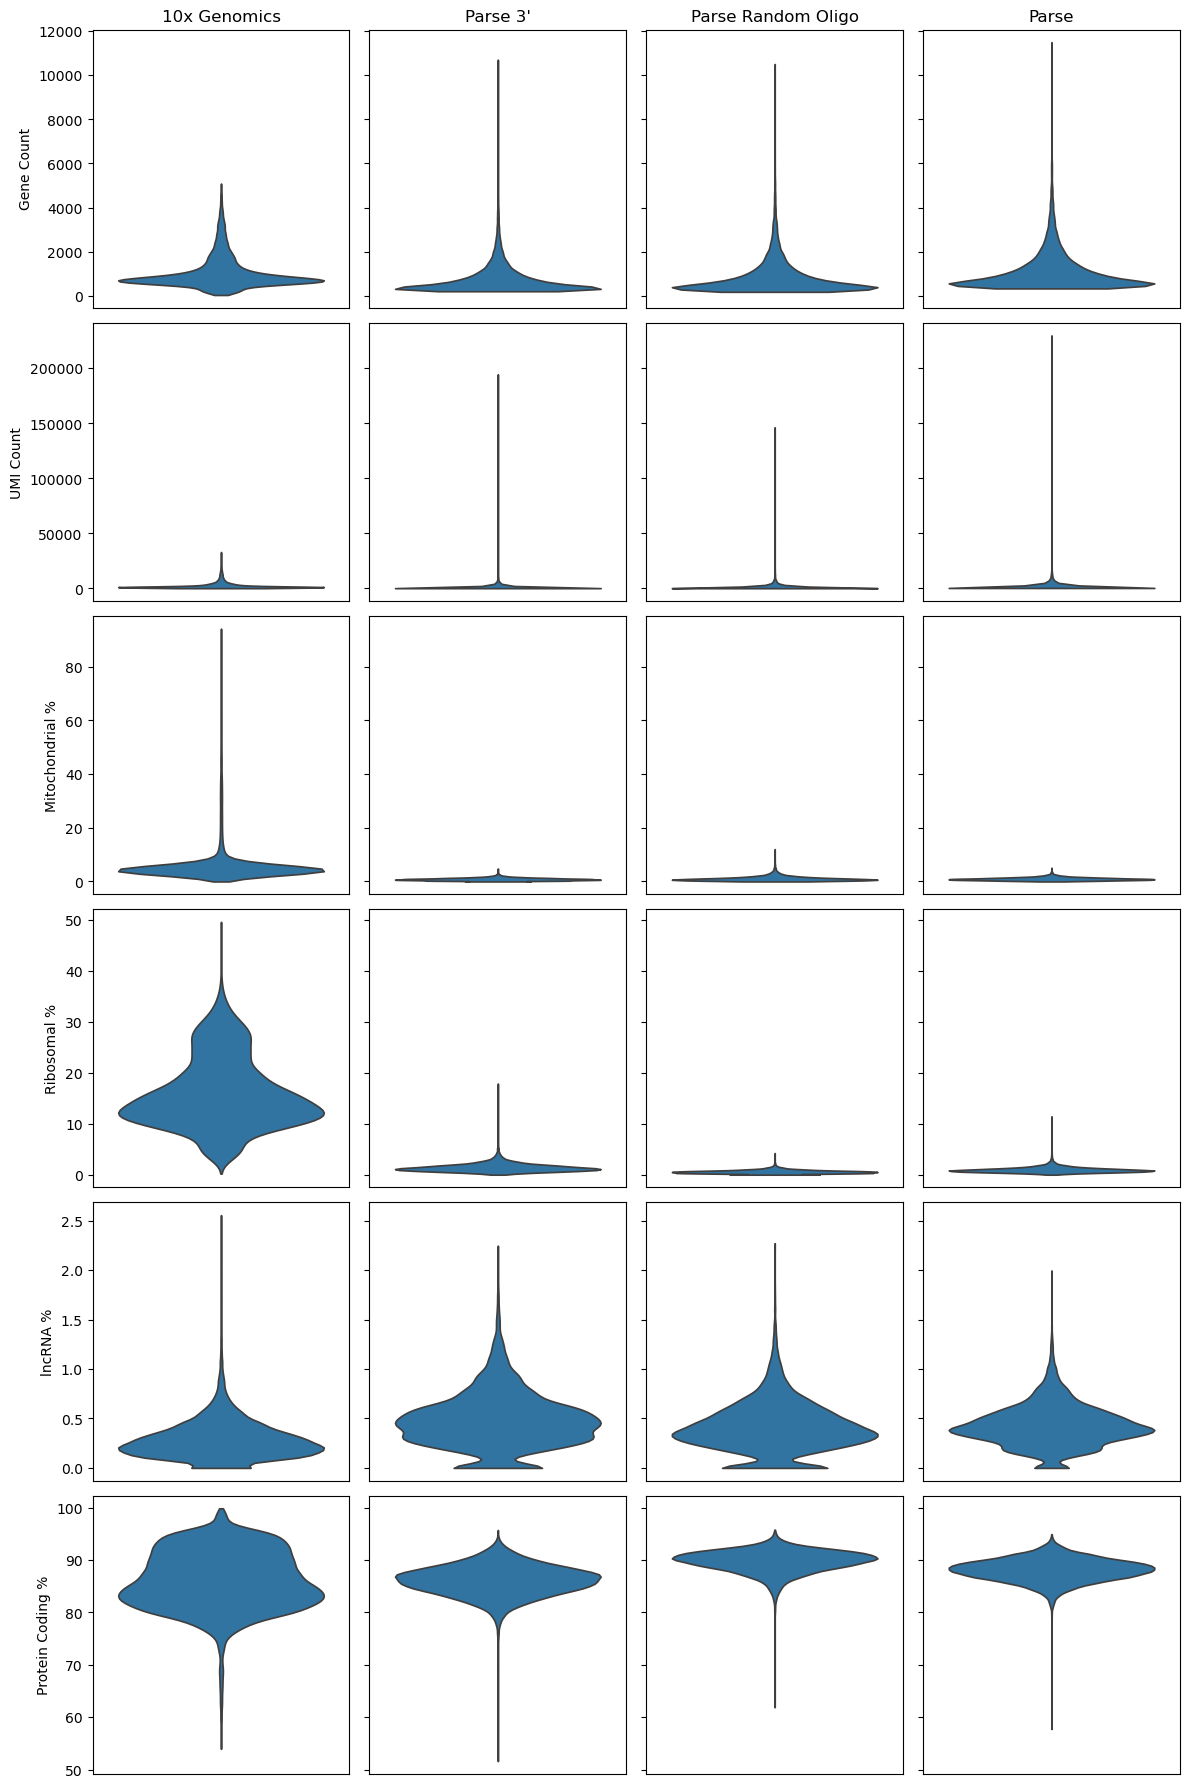

In [25]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc', 'percent_pc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %', 'Protein Coding %']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
for i, data in enumerate(datasets):
    violin_plots(ax[:, i], data, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, data in enumerate(datasets):
    ax[0,i].set_title(data.uns['title'])

plt.tight_layout()
plt.show()

In [26]:
# Create a dataframe of genes from which to query attributes
gene_df = gene_lengths.copy()
gene_df = gene_df.merge(gc_content, on = ['gene_id','gene_name'])
gene_df = gene_df.merge(biotype_result, on = ['gene_id','gene_name'])
gene_df.loc[:,'is_lnc'] = False
gene_df.loc[gene_df['gene_id'].isin(lnc_result['gene_id']),'is_lnc'] = True
gene_df.loc[:,'is_pc'] = False
gene_df.loc[gene_df['gene_id'].isin(pc_result['gene_id']),'is_pc'] = True
gene_df["is_mito"] = gene_df['gene_name'].str.startswith("mt")
gene_df["is_ribo"] = gene_df['gene_name'].str.startswith(("Rps", "Rpl"))

In [27]:
for data in datasets:
    gene_df = gene_df.merge(data.var[['gene_id','n_cells','percent_counts']], on = ['gene_id'])
    gene_df.rename(columns={'n_cells':data.uns['name']+'_n_cells', 
                            'percent_counts':data.uns['name']+'_percent_counts'}, 
                            inplace=True)

In [28]:
gene_df = gene_df.drop_duplicates(subset = ['gene_id','gene_name'])

In [29]:
gene_df.to_csv('gene_attributes.csv')

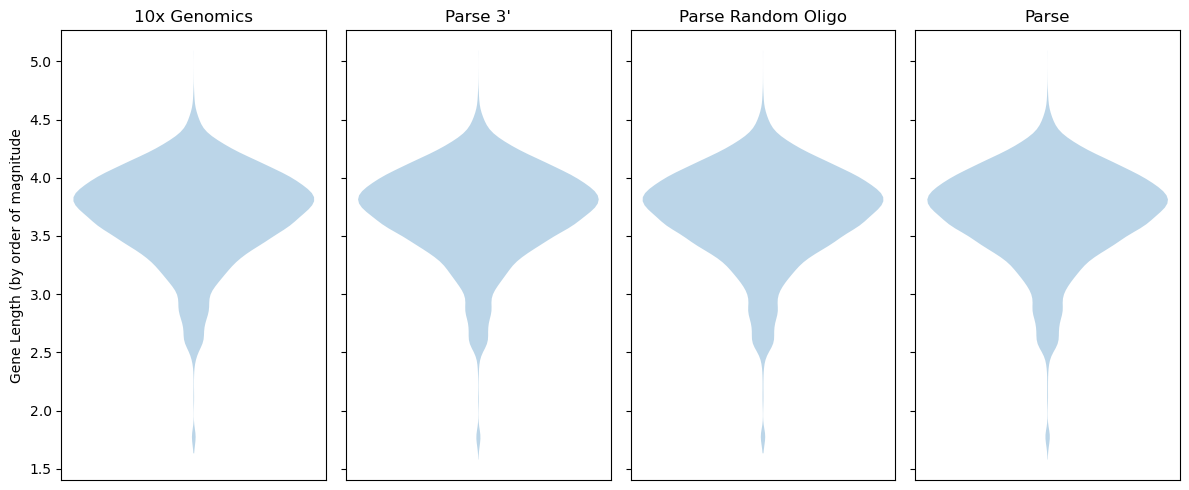

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    lengths = data.var['gene_length'][data.var['gene_length']>1]
    ax[i].violinplot(np.log10(lengths),showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Gene Length (by order of magnitude')


plt.tight_layout()
plt.show()

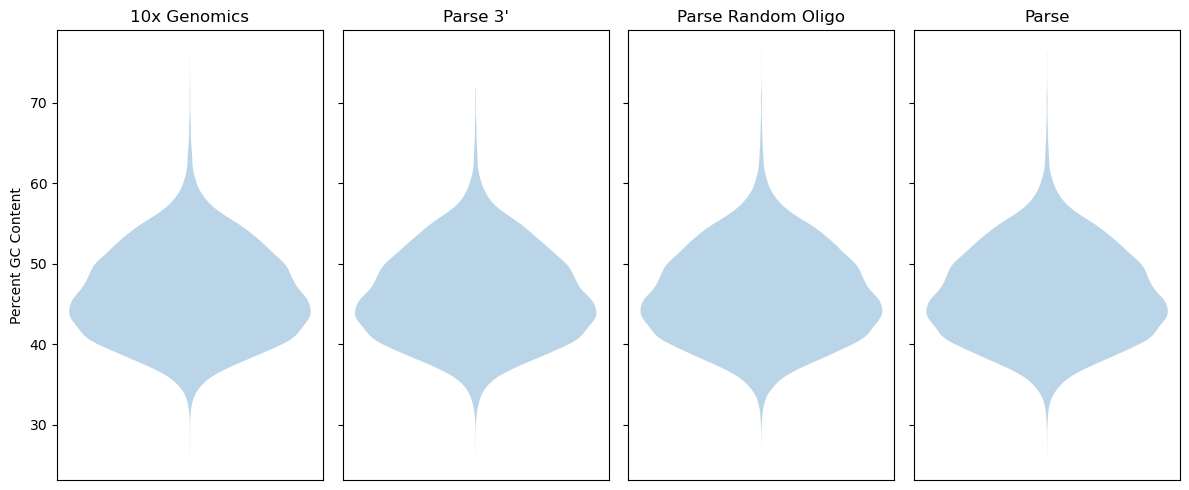

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    gcs = data.var.loc[data.var['gc_content']>0,'gc_content']
    ax[i].violinplot(gcs,showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

# Read/Gene Comparisons

In [32]:
T_marker_names = ['Cd3d', 'Cd3g', 'Cd4', 'Cd8a',
                'Il2ra', 'Themis', 'Cd28', 'Foxp3',
                'Cd3e']
T_receptor_names = ['Trbv','Trav', 'Trgv', 'Trdv']
T_markers = ['ENSMUSG00000032094.9', 'ENSMUSG00000002033.15', 'ENSMUSG00000023274.15', 'ENSMUSG00000053977.14',
           'ENSMUSG00000026770.6', 'ENSMUSG00000049109.16', 'ENSMUSG00000026012.3', 'ENSMUSG00000039521.14',
           'ENSMUSG00000032093.8']
T_marker_types = ['Pan T cells', 'Pan T cells', 'Helper T cells', 'Cytotoxic T cells',
                'Regulatory T cells', 'Thymocyte Selection', 'Naive T cells',
                'Pan T cells']
T_marker_protein = ['receptor', 'receptor', 'receptor', 'receptor',
                  'receptor', 'regulator', 'receptor', 'transcription factor',
                  'receptor']

# Indicative of epithelial cells
cytokeratin_names = ['Krt']

In [33]:
# Add percent of counts for each transcript to metadata
for data in datasets: 
    data.var['percent_counts'] = data.X.sum(axis=0).A1 / data.X.sum() * 100

In [34]:
def marker_genes(ax, data, markers):
    gene_dist = []
    for gene in markers:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(markers) + 1), markers)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Thymus Marker Genes")

def collapsed_marker_genes(ax, data, marker_prefixes):
    genes = data.var

    gene_dist = []
    for prefix in marker_prefixes:
        mask = genes[genes.index.str.startswith(prefix)].index
        gene_dist.append(np.nan_to_num(data[:,mask].X.toarray().sum(axis=1).transpose() / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(marker_prefixes) + 1), marker_prefixes)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Thymus Marker Genes")

# Displays violin plots of the distributions of the top 10 expressed gene/transcripts
# (by number of cells expressed in) by cell
def top_gene_cell_expression(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Top 10 Genes by Cell Expression")

def top_gene_counts(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='percent_counts',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Top 10 Genes by Total Counts")

# compares the gene count percentatages between two methods
def compare_genes(data_x, data_y):
    x_var = data_x.var.reset_index(names='gene_names')
    x_var.drop('n_cells', axis=1,inplace=True)

    y_var = data_y.var.reset_index(names='gene_names')
    y_var.drop('n_cells',axis=1,inplace=True)

    shared_data = pd.merge(x_var, y_var, on=['gene_names','gene_id','gene_length', 'gc_content'], how='outer')
    shared_data.fillna(0,inplace=True)

    for col in ['is_lnc','is_mito','is_ribo','is_pc']:
        shared_data[col] = shared_data[col+"_x"] | shared_data[col+"_y"]
        shared_data.drop(col+"_x",axis=1,inplace=True)
        shared_data.drop(col+"_y",axis=1,inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data['percent_counts_y'], shared_data['percent_counts_x']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    #calculate point density
    xy = np.vstack([shared_data['percent_counts_x'].to_numpy().flatten(), shared_data['percent_counts_y'].to_numpy().flatten()])
    shared_data['point_density'] = gaussian_kde(xy)(xy)

    return shared_data

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def scatter_genes(ax, shared_data, data_x, data_y, c_column,  xlim = None, ylim = None, norm = None):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    plot = ax.scatter(x_percent, 
                y_percent, 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data[c_column], 
                cmap='viridis')
    
    ax.set_xlabel(data_x.uns['title'] + ' Gene Percent Count')
    ax.set_ylabel(data_y.uns['title'] + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def cat_scatter_genes(ax, shared_data, data_x, data_y, color, label=None, xlim = None, ylim = None):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    plot = ax.scatter(x_percent, 
                y_percent, 
                s=50,
                alpha=0.5, 
                c=color,
                label=label)
    
    ax.set_xlabel(data_x.uns['title'] + ' Gene Percent Count')
    ax.set_ylabel(data_y.uns['title'] + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

def show_correlation(ax, shared_data):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    #Calculate correlation
    pearson_r = pearsonr(x_percent, y_percent).correlation
    spearman_r = spearmanr(x_percent, y_percent).correlation
    
    x_mean = x_percent.mean()
    y_mean = y_percent.mean()
    x_std = x_percent.std()
    y_std = y_percent.std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)    

    ax.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1.5)  # y=x line

    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return

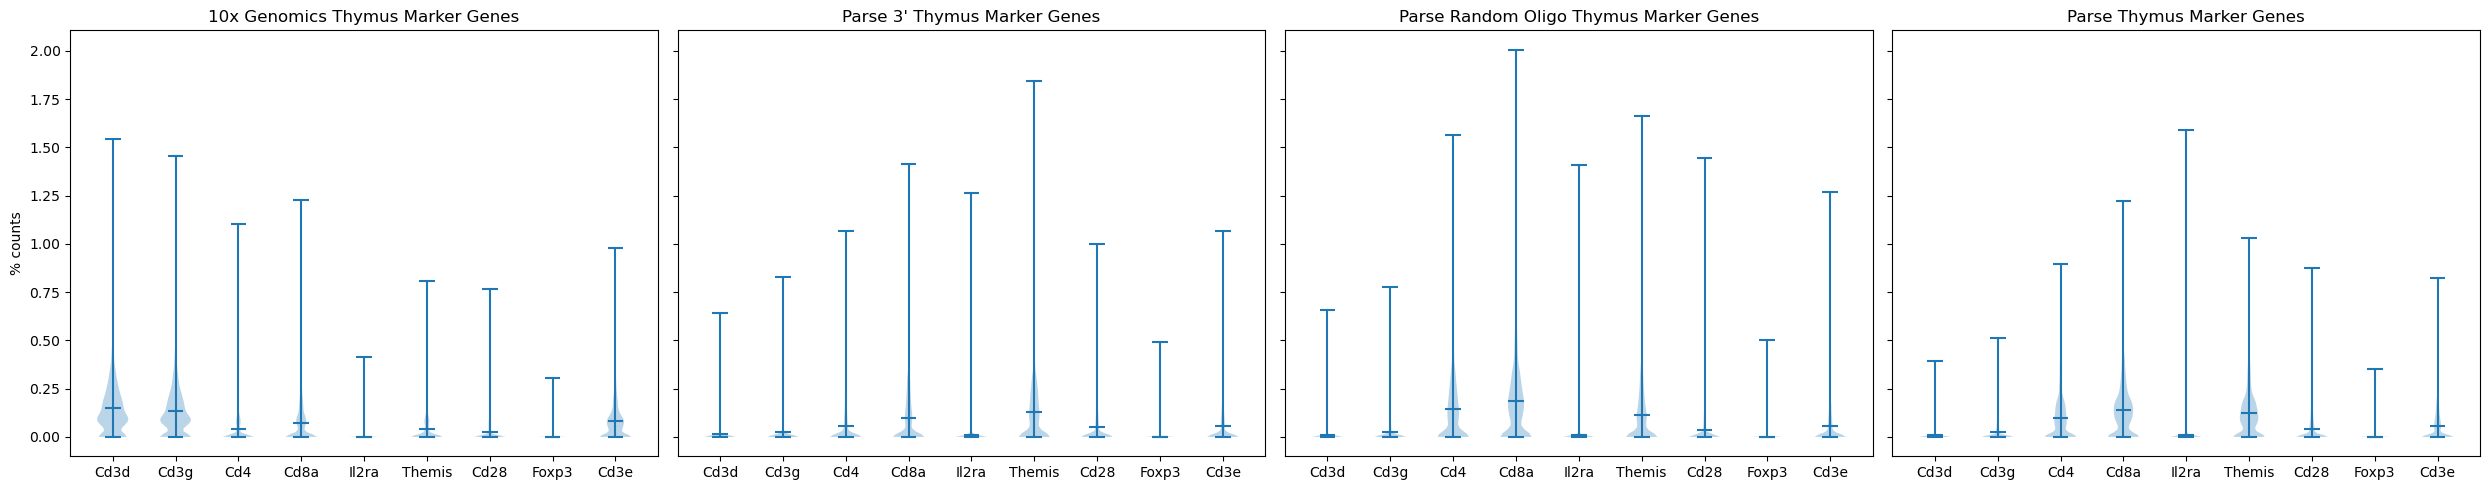

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    marker_genes(ax[i], data, T_marker_names)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

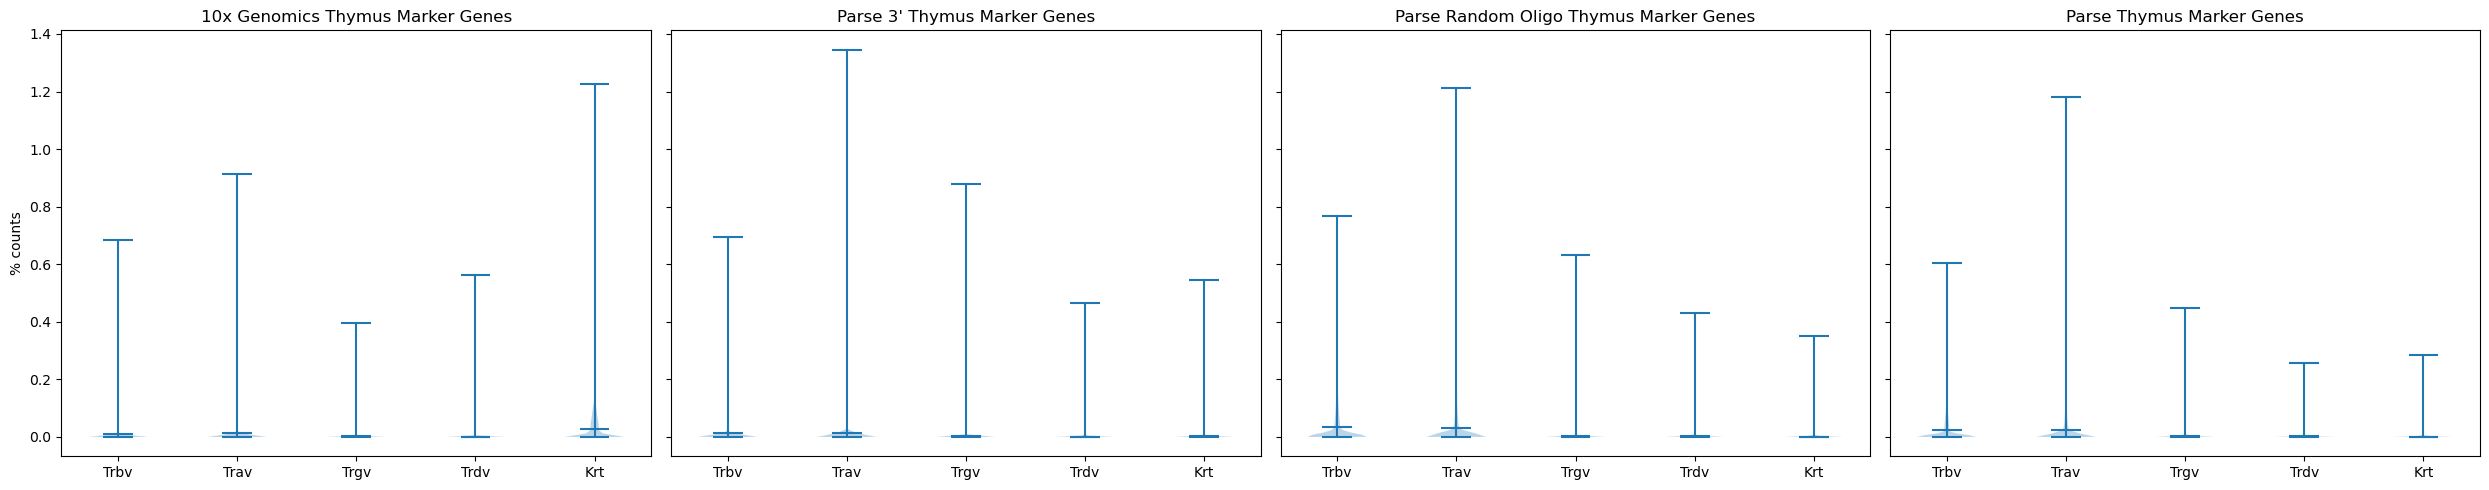

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    collapsed_marker_genes(ax[i], data, T_receptor_names + cytokeratin_names)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

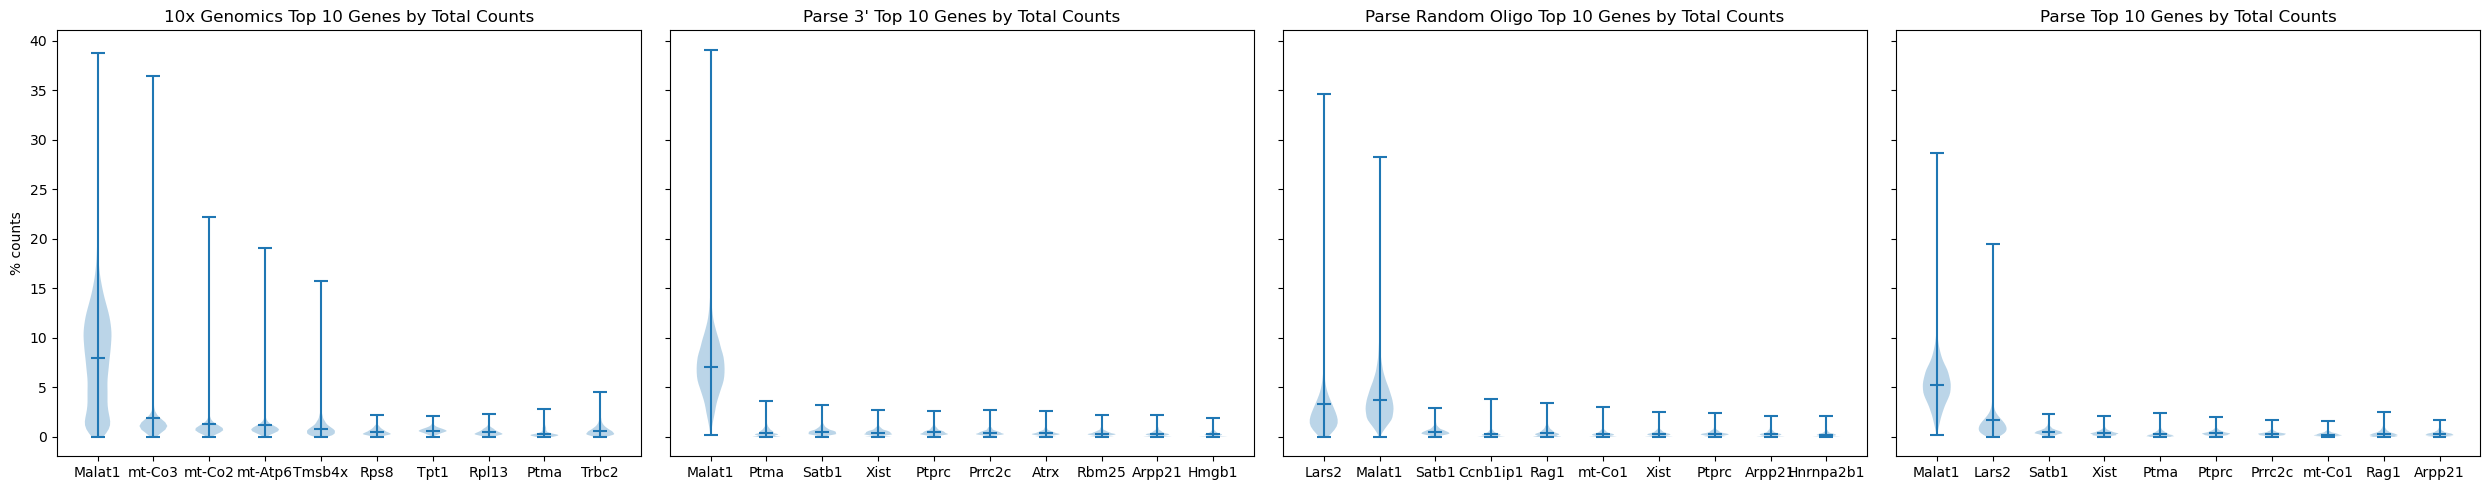

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    top_gene_counts(ax[i], data)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

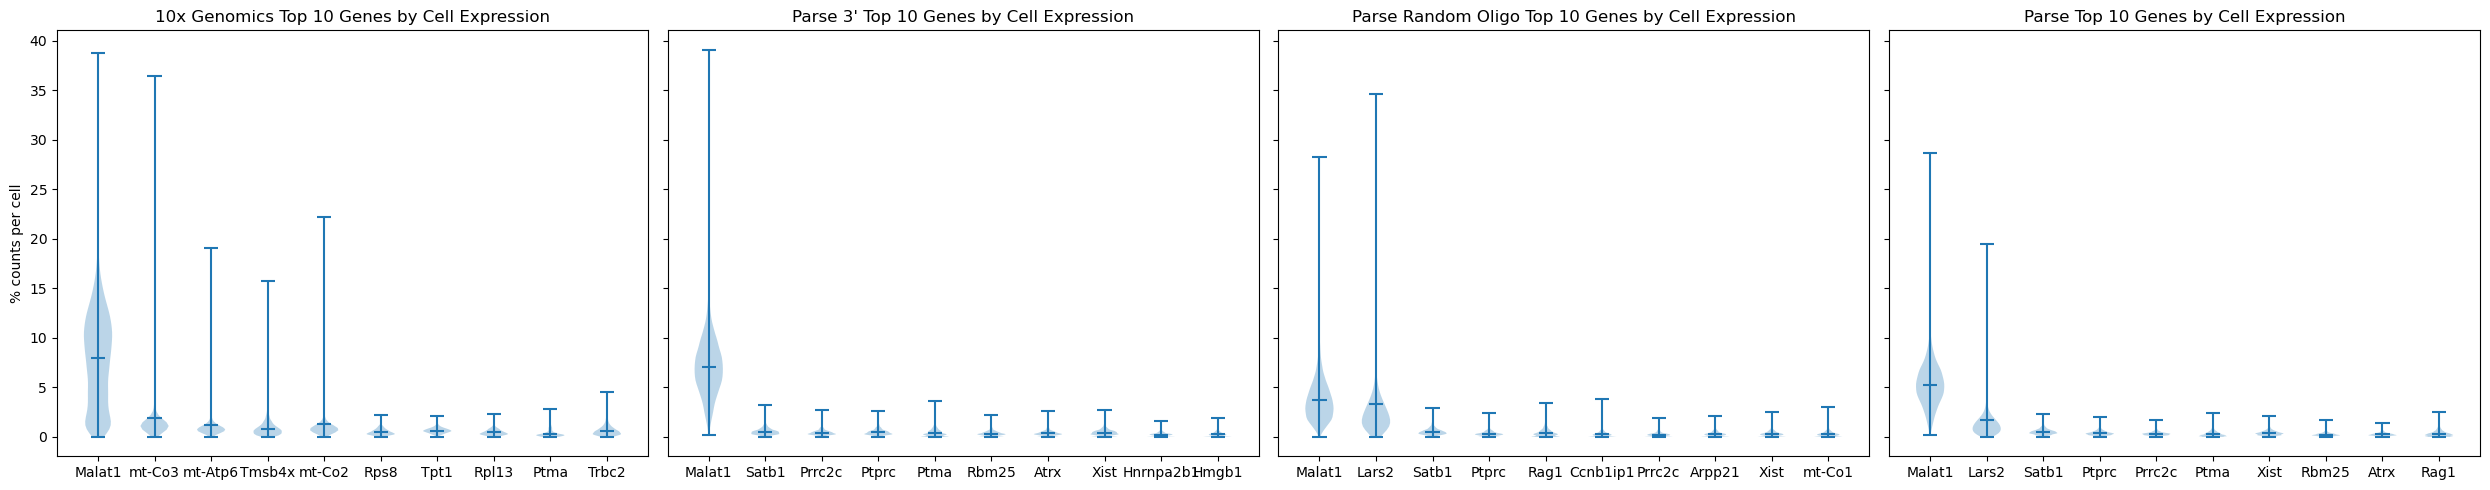

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
for i, data in enumerate(datasets):
    top_gene_cell_expression(ax[i], data)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

In [97]:
lim = 8

data_10x = datasets[0]
data_polyT = datasets[1]
data_randO = datasets[2]
data_parse = datasets[3]

comparisons = [(data_polyT,data_randO),
               (data_10x,data_polyT),
               (data_10x,data_randO),
               (data_10x,data_parse)]

compare_dfs = []
for pair in comparisons:
    compare_dfs.append(compare_genes(pair[0],pair[1]))

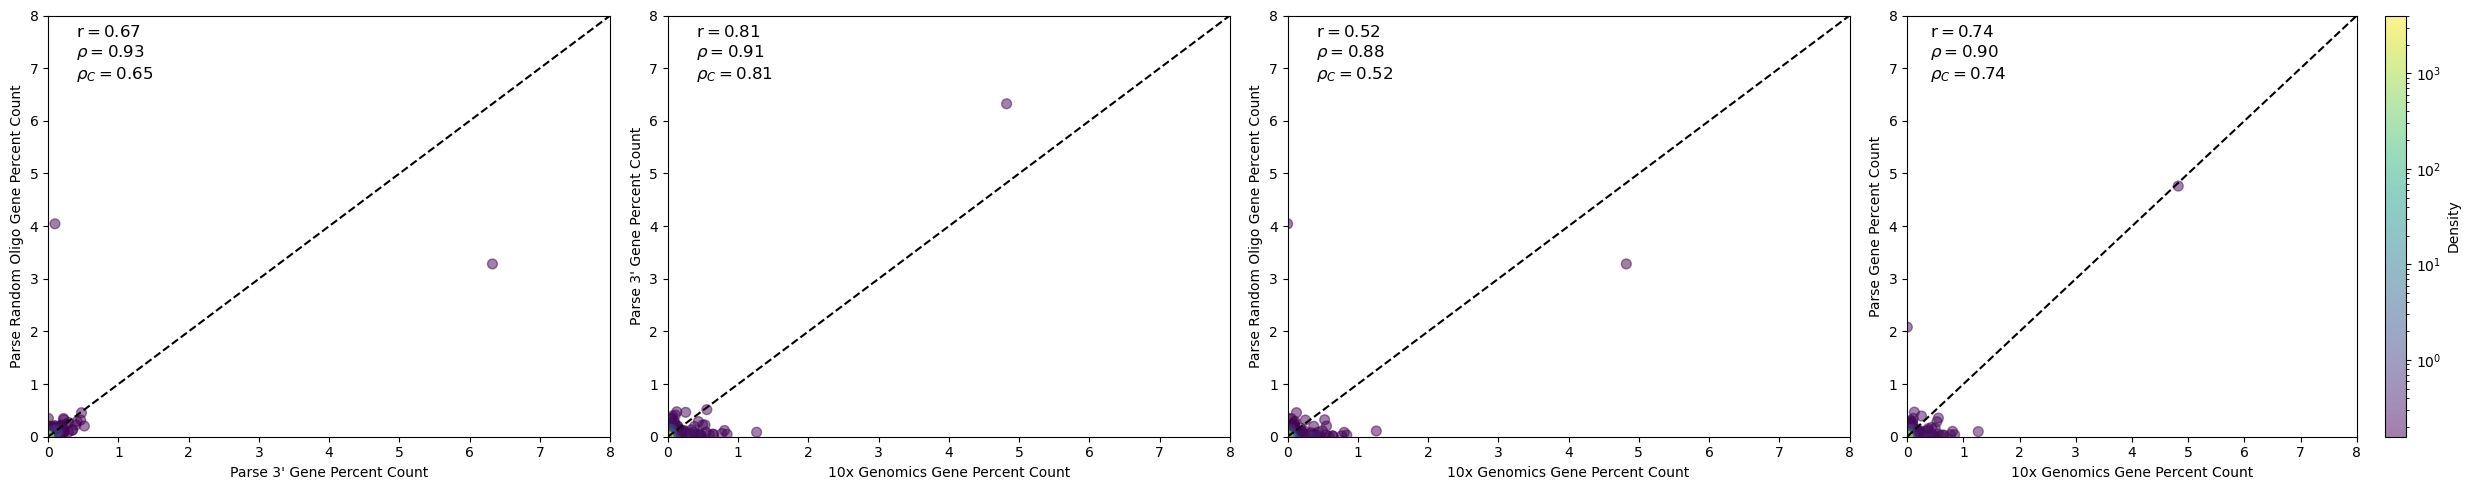

In [98]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['point_density'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'point_density', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Density")

plt.tight_layout()
plt.show()

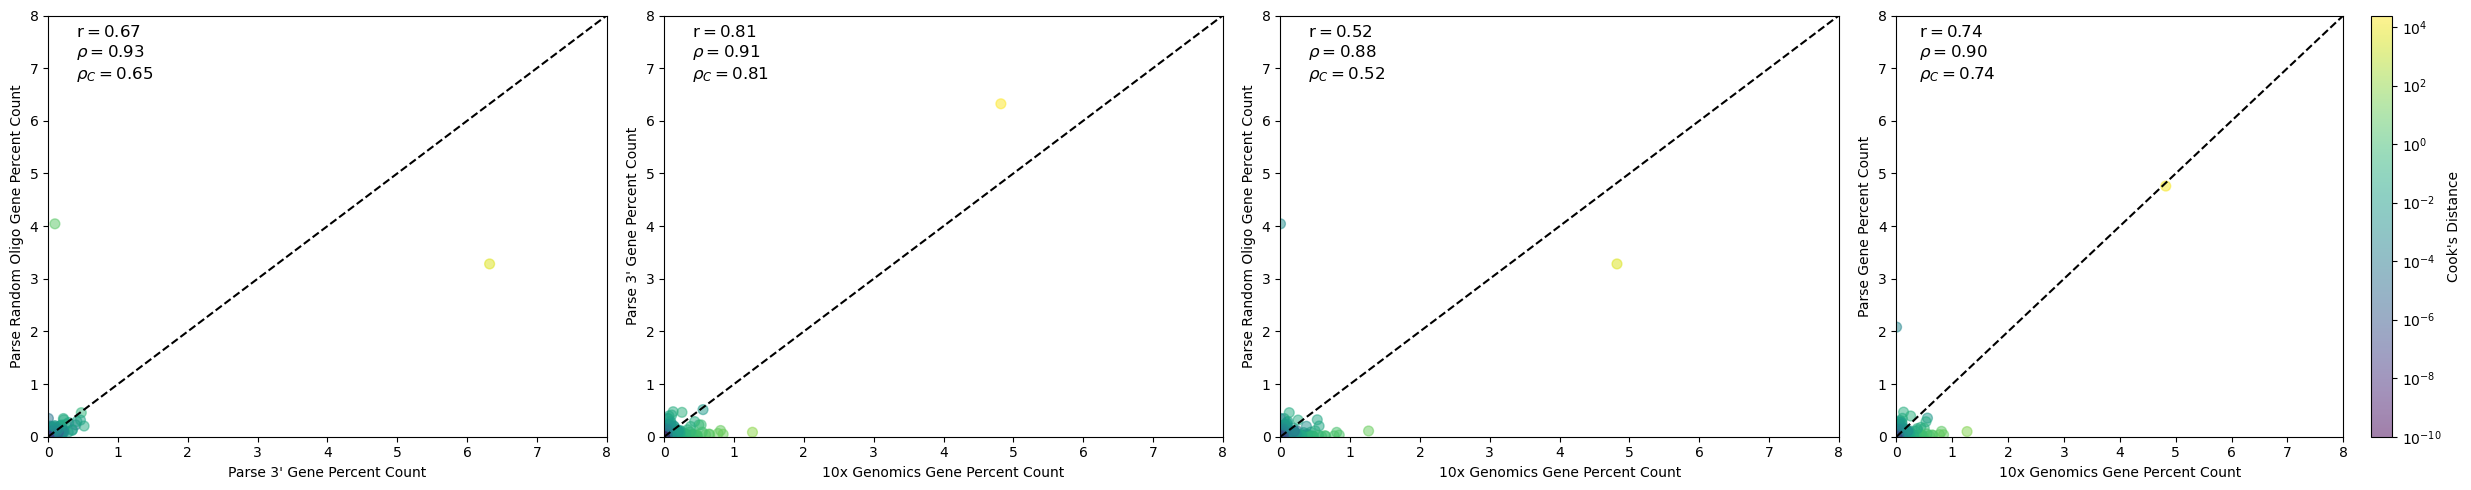

In [99]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['cooks_distance'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'cooks_distance', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

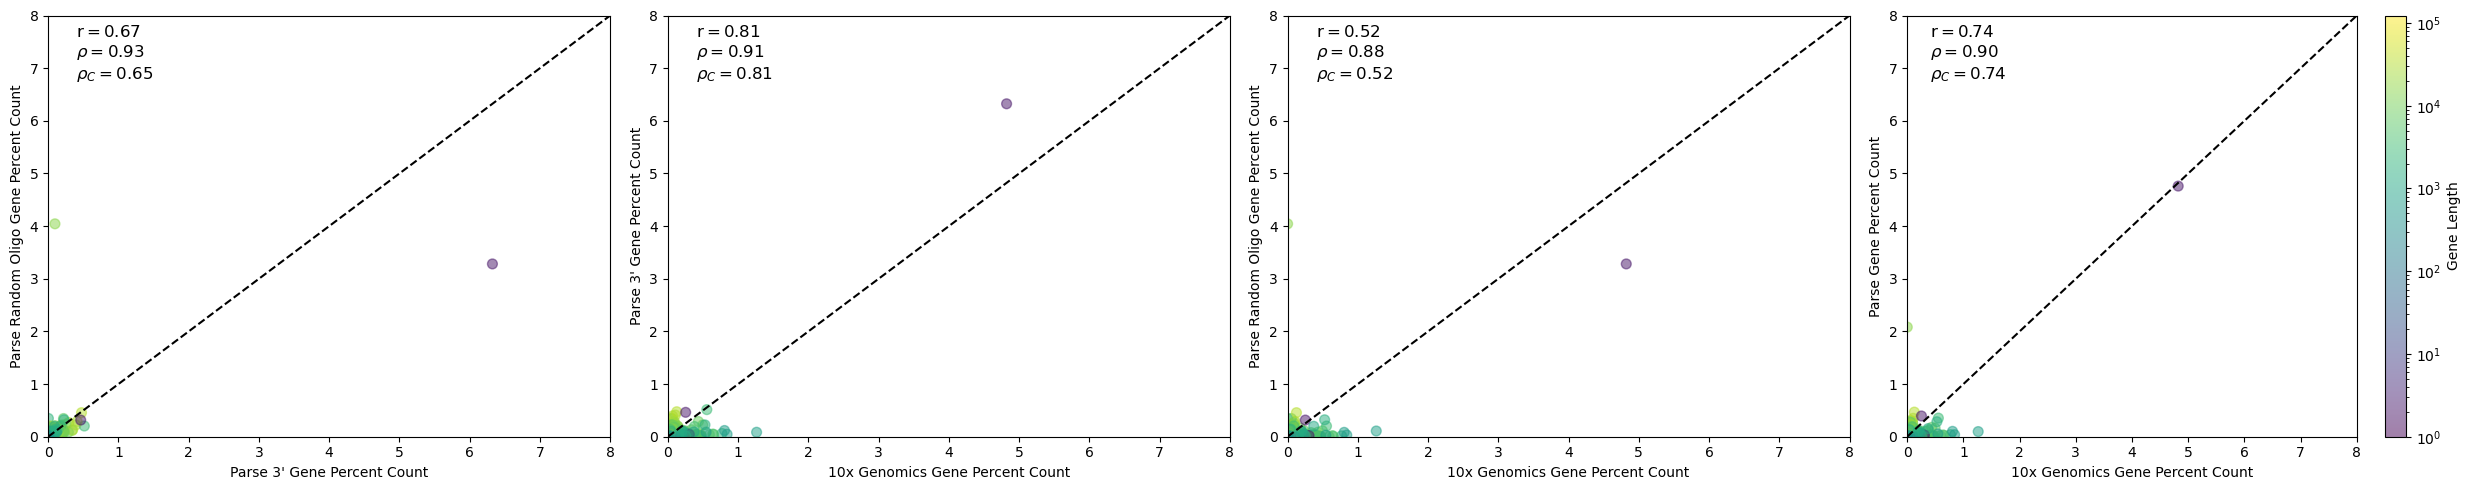

In [100]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    df['gene_length'] = df['gene_length']+1
    c_values.extend(df['gene_length'].tolist())
norm = LogNorm(1, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gene_length', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Gene Length")

plt.tight_layout()
plt.show()

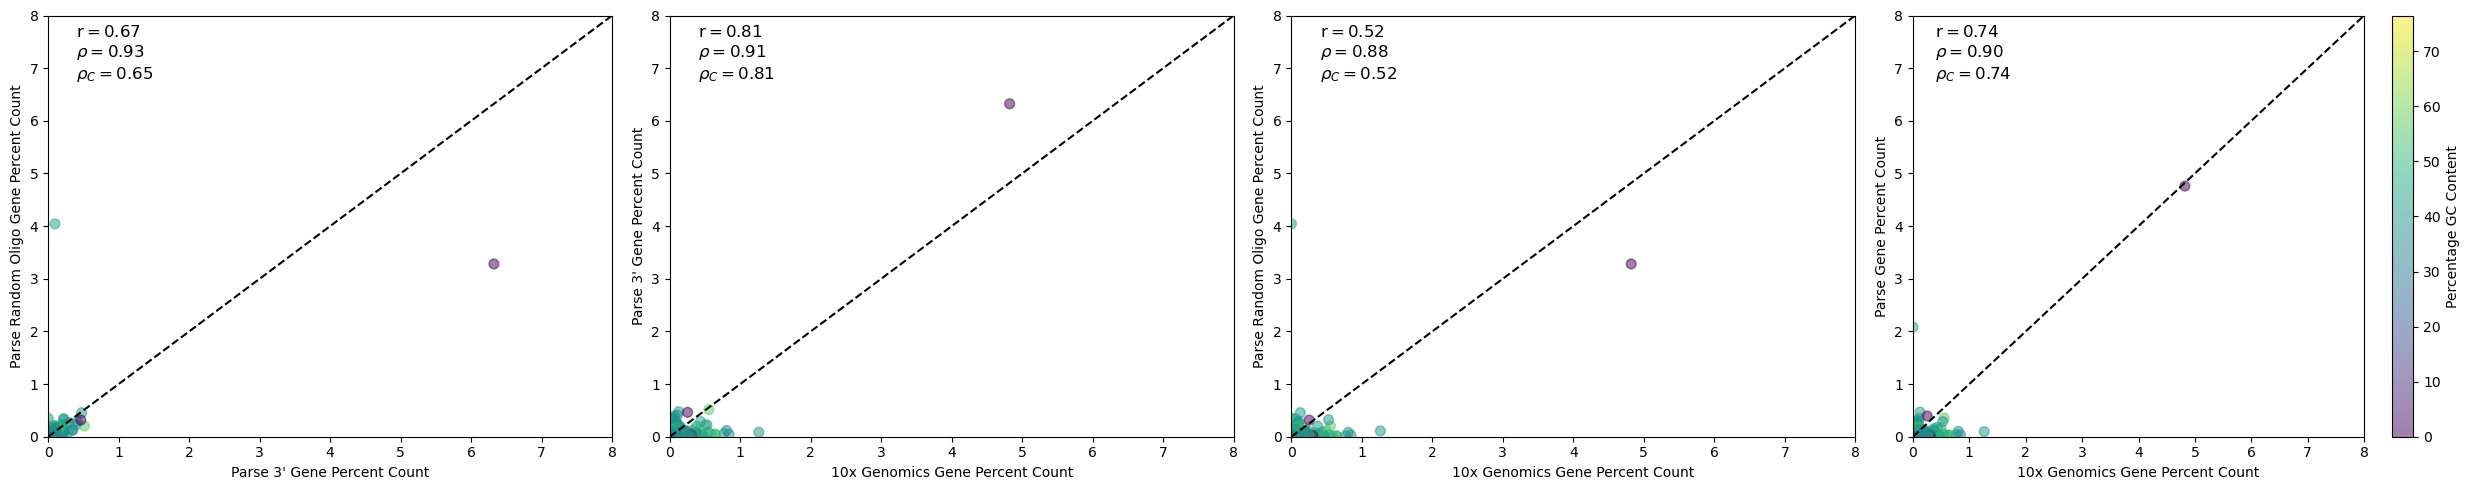

In [101]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['gc_content'].tolist())
norm = Normalize(0, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gc_content', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Percentage GC Content")

plt.tight_layout()
plt.show()

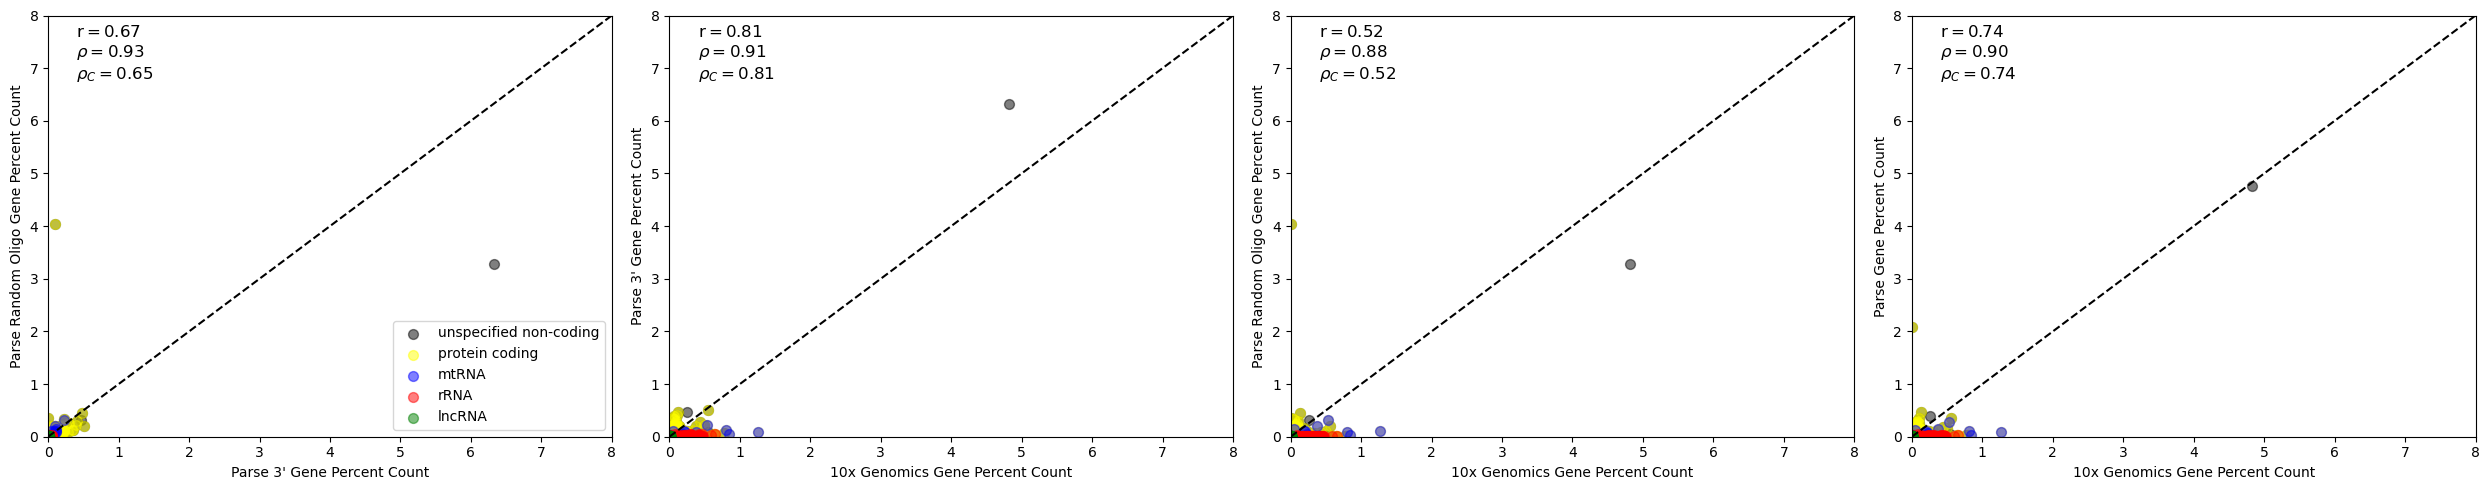

In [102]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                      pair[0], pair[1],'black', 
                      label = 'unspecified non-coding', xlim=lim, ylim=lim)
    for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                            ['yellow', 'blue', 'red', 'green'],
                            ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
        cat_scatter_genes(ax, df[df[col]], pair[0], pair[1], 
                          c, label=label,xlim=lim, ylim=lim)

    show_correlation(ax,df)
    
axs[0].legend()

plt.tight_layout()
plt.show()

In [103]:
lim = 1

data_10x = datasets[0][:,datasets[0].var['percent_counts'] < lim]
data_polyT = datasets[1][:,datasets[1].var['percent_counts'] < lim]
data_randO = datasets[2][:,datasets[2].var['percent_counts'] < lim]
data_parse = datasets[3][:,datasets[3].var['percent_counts'] < lim]

comparisons = [(data_polyT,data_randO),
               (data_10x,data_polyT),
               (data_10x,data_randO),
               (data_10x,data_parse)]

compare_dfs = []
for pair in comparisons:
    compare_dfs.append(compare_genes(pair[0],pair[1]))

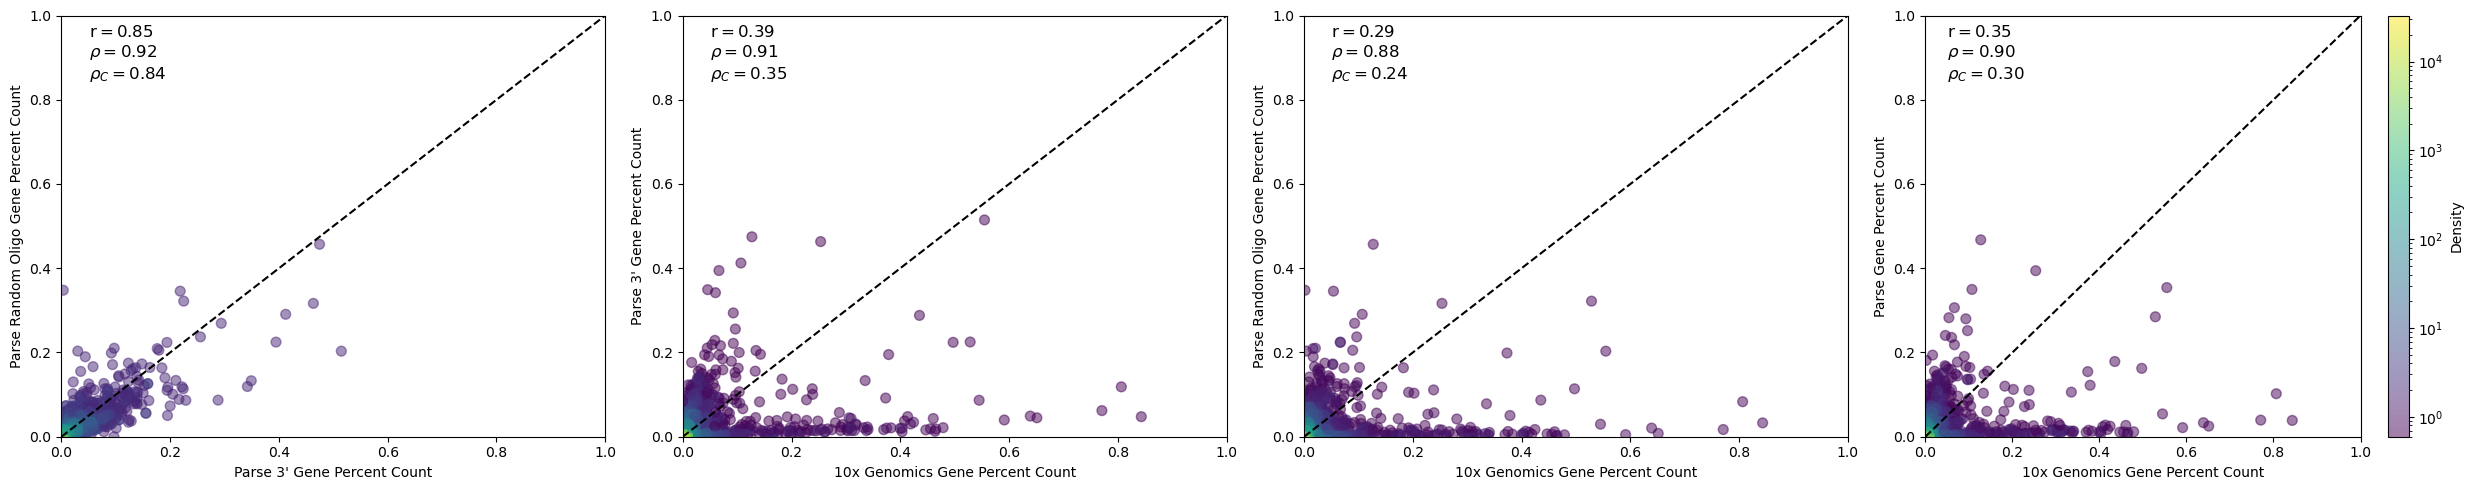

In [104]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['point_density'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'point_density', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Density")

plt.tight_layout()
plt.show()

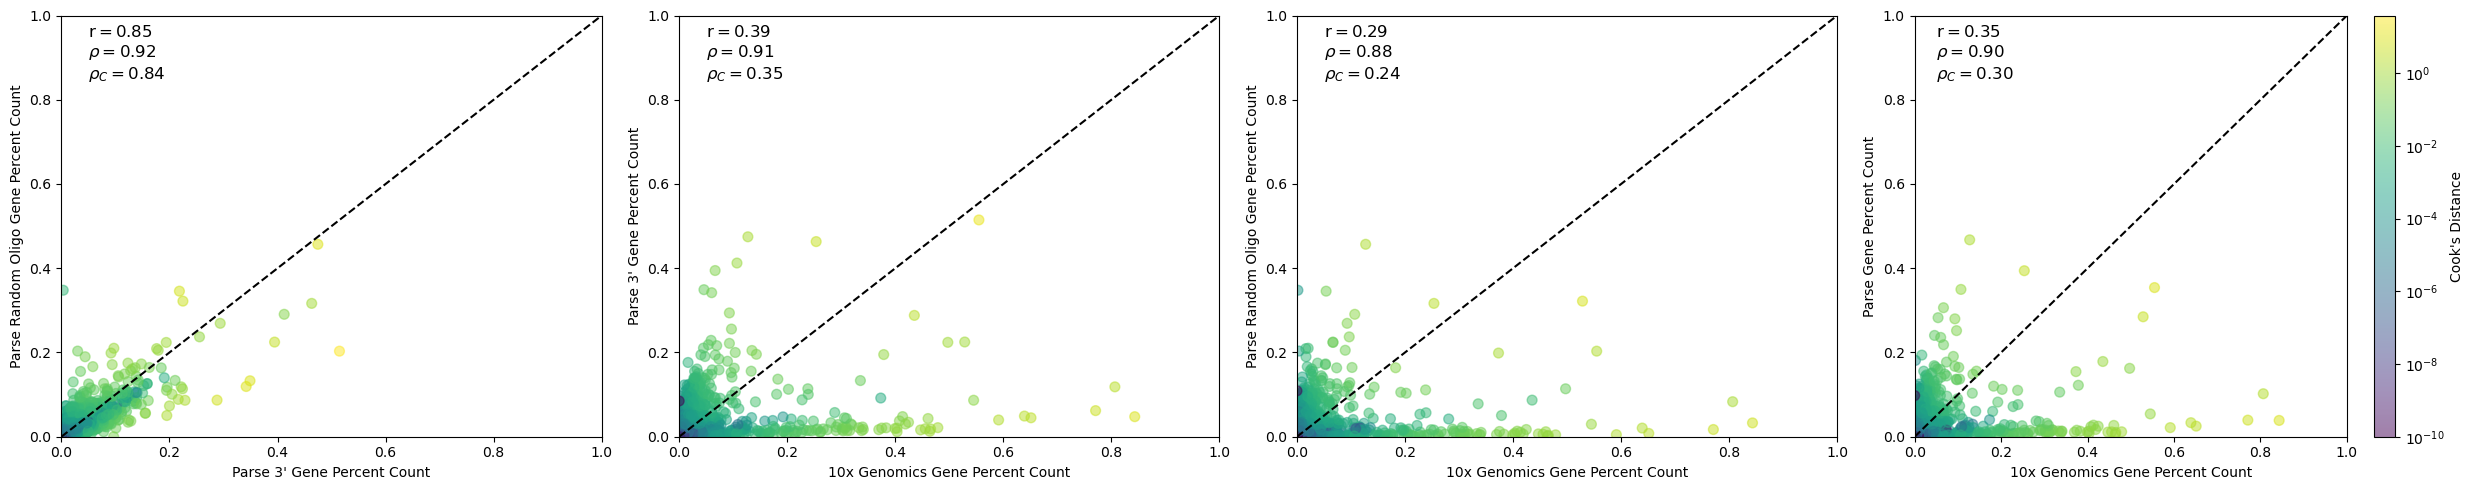

In [105]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['cooks_distance'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'cooks_distance', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

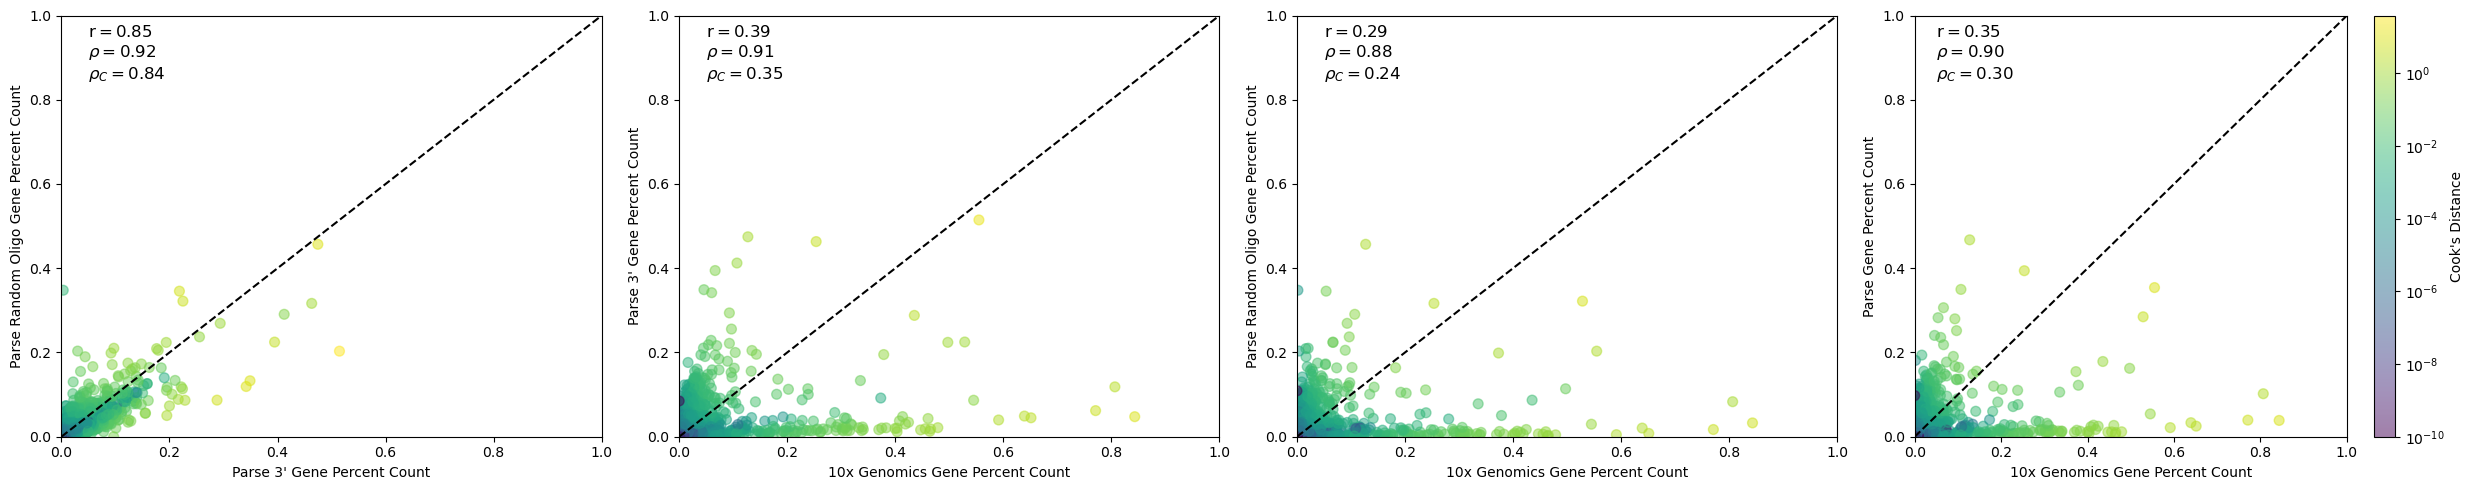

In [106]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['cooks_distance'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'cooks_distance', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

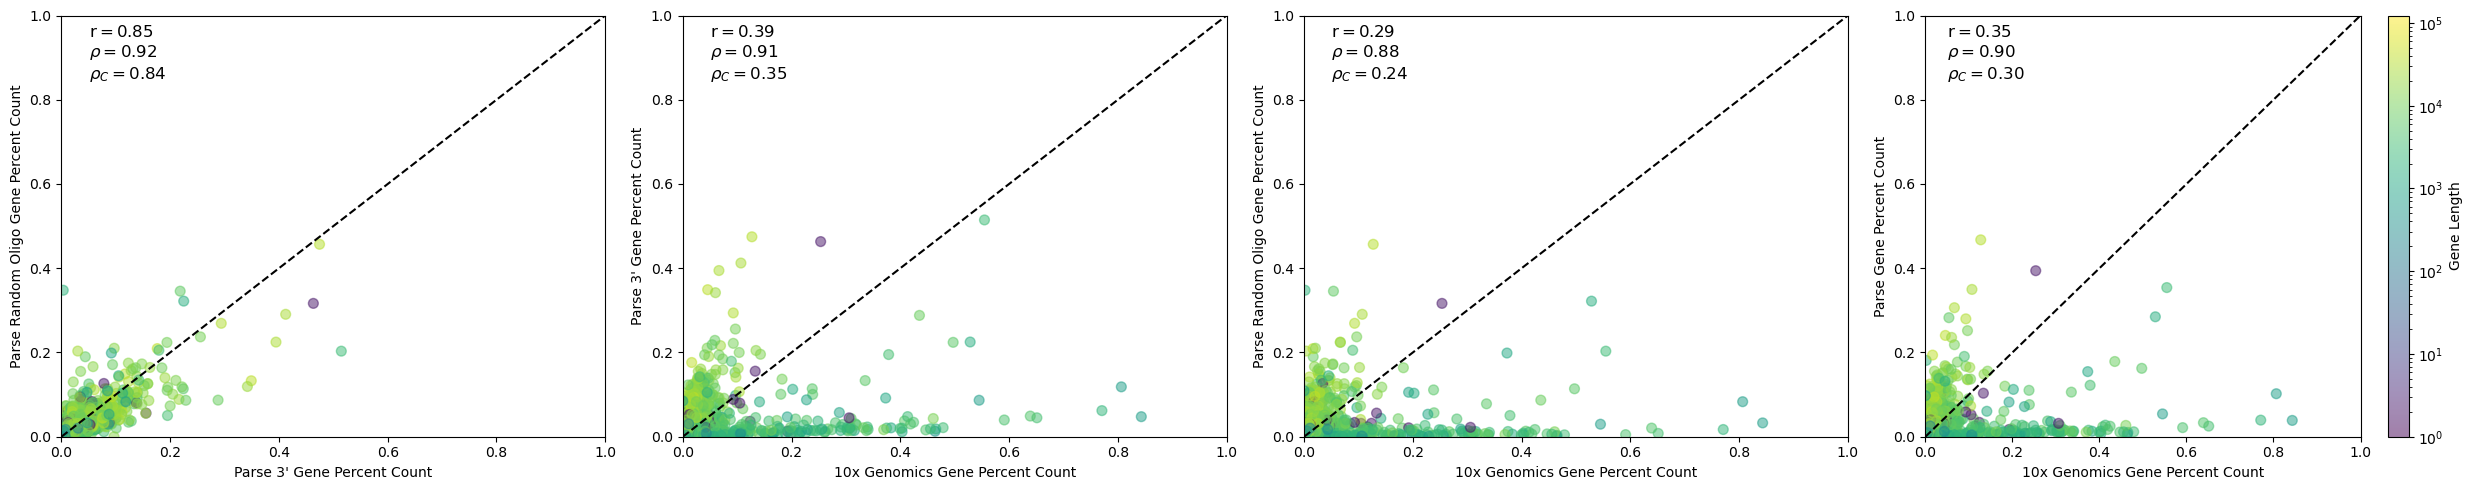

In [107]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    df['gene_length'] = df['gene_length']+1
    c_values.extend(df['gene_length'].tolist())
norm = LogNorm(1, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gene_length', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Gene Length")

plt.tight_layout()
plt.show()

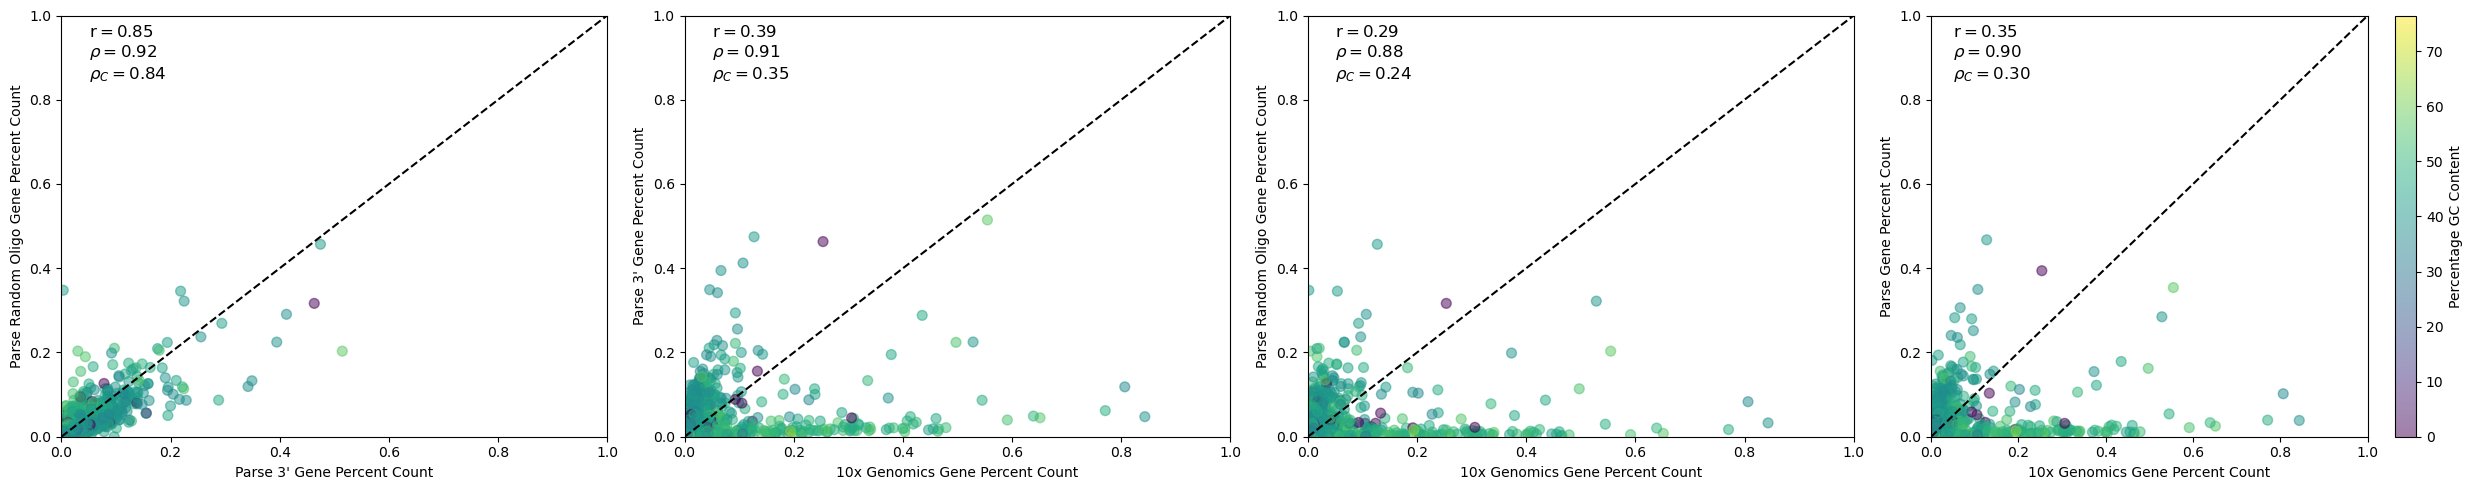

In [108]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['gc_content'].tolist())
norm = Normalize(0, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gc_content', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Percentage GC Content")

plt.tight_layout()
plt.show()

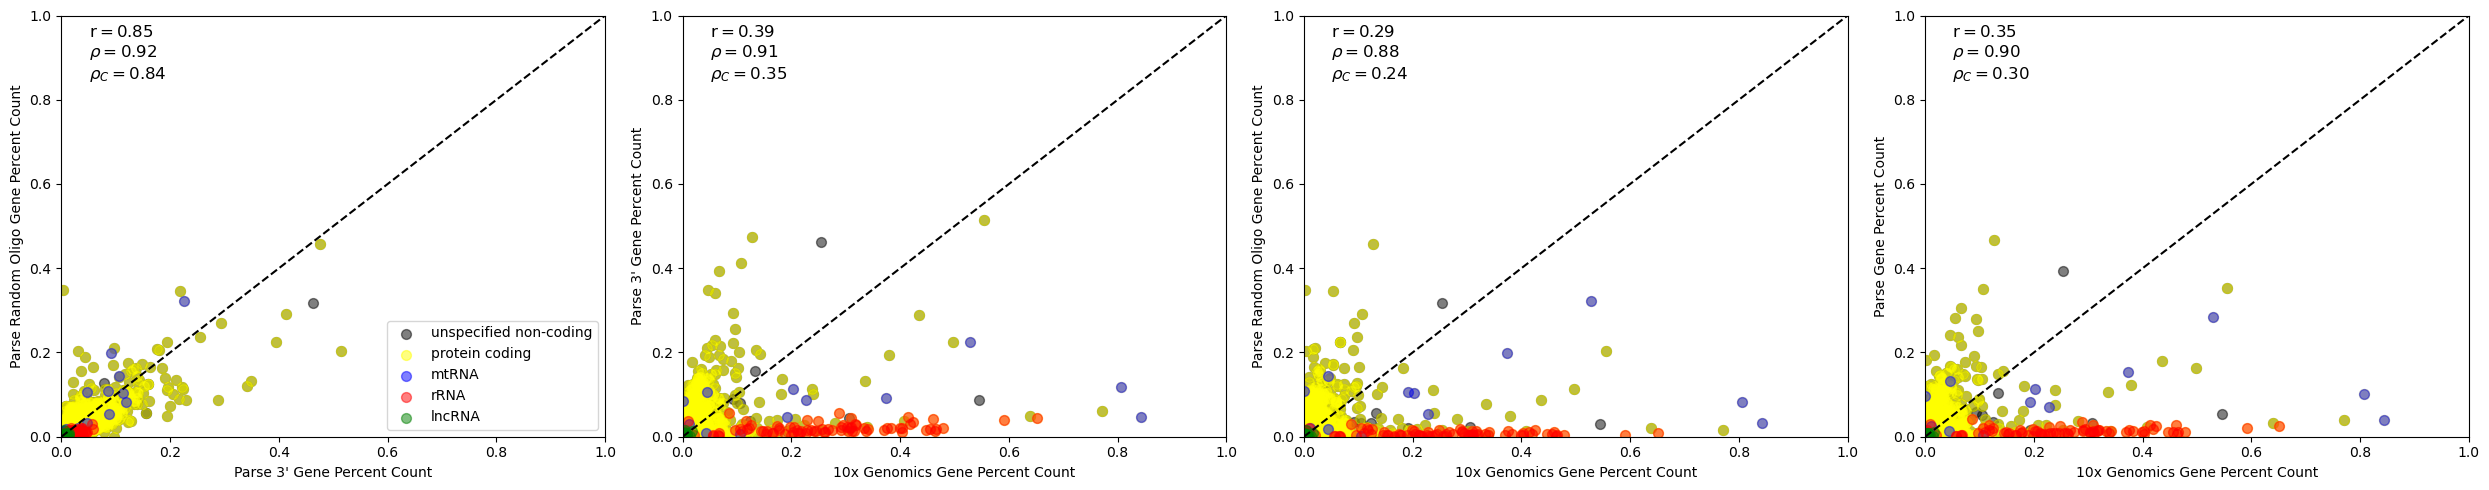

In [109]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                      pair[0], pair[1],'black', 
                      label = 'unspecified non-coding', xlim=lim, ylim=lim)
    for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                            ['yellow', 'blue', 'red', 'green'],
                            ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
        cat_scatter_genes(ax, df[df[col]], pair[0], pair[1], 
                          c, label=label,xlim=lim, ylim=lim)

    show_correlation(ax,df)
    
axs[0].legend()

plt.tight_layout()
plt.show()

In [110]:
lim = 0.1

data_10x = datasets[0][:,datasets[0].var['percent_counts'] < lim]
data_polyT = datasets[1][:,datasets[1].var['percent_counts'] < lim]
data_randO = datasets[2][:,datasets[2].var['percent_counts'] < lim]
data_parse = datasets[3][:,datasets[3].var['percent_counts'] < lim]

comparisons = [(data_polyT,data_randO),
               (data_10x,data_polyT),
               (data_10x,data_randO),
               (data_10x,data_parse)]

compare_dfs = []
for pair in comparisons:
    compare_dfs.append(compare_genes(pair[0],pair[1]))

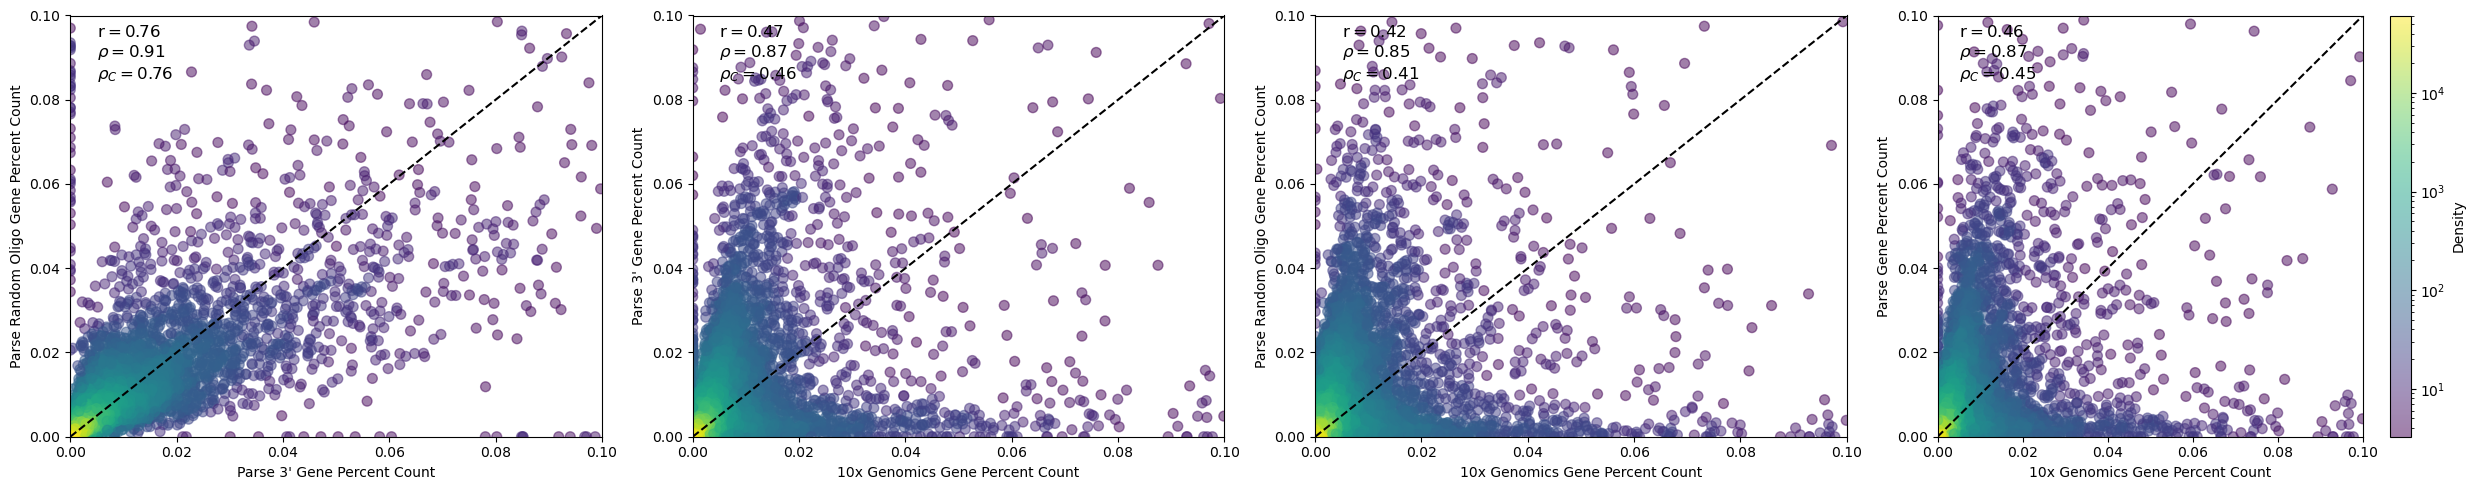

In [111]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['point_density'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'point_density', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Density")

plt.tight_layout()
plt.show()

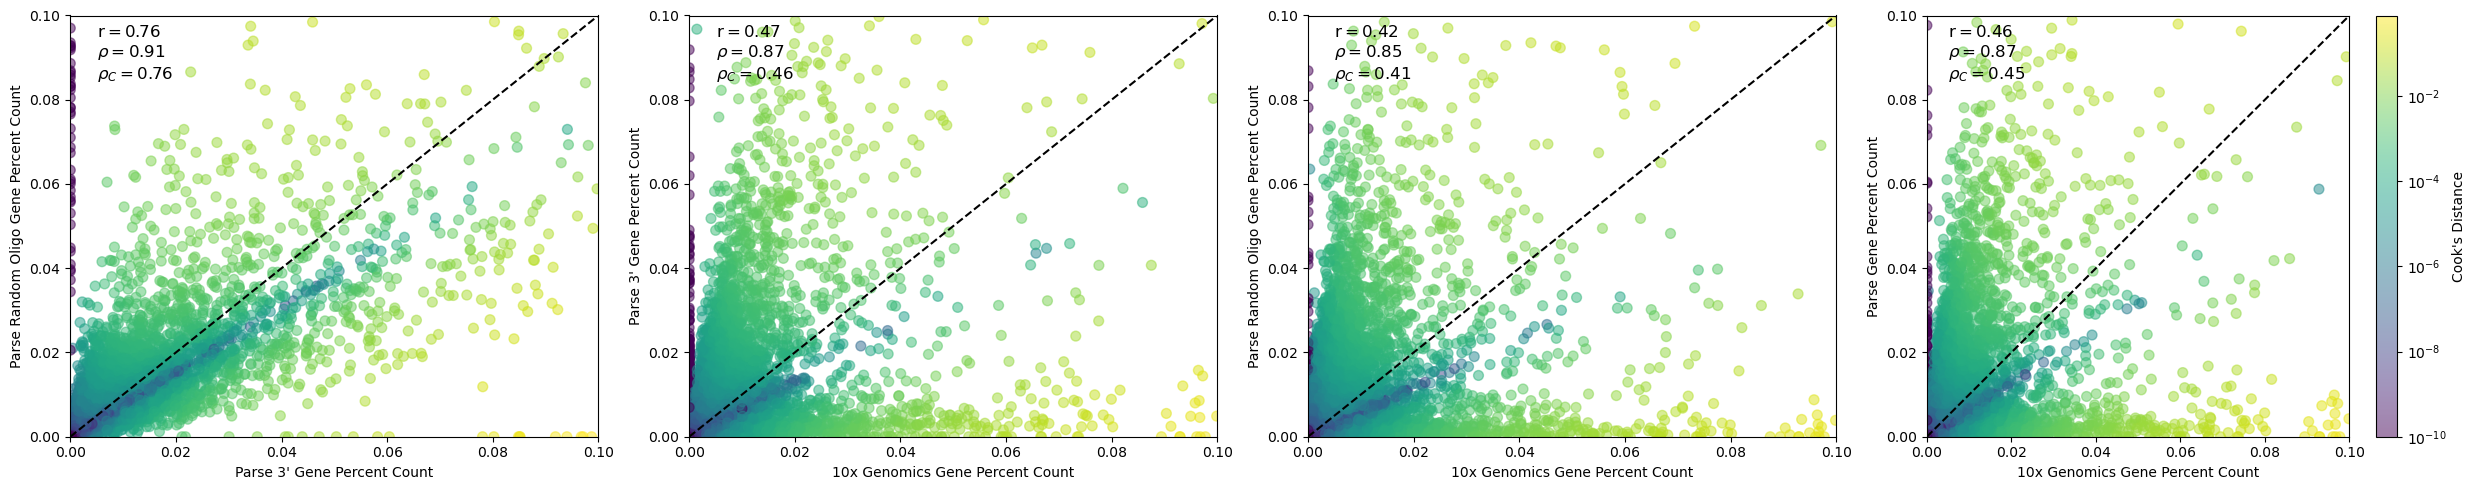

In [112]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['cooks_distance'].tolist())
norm = LogNorm(min(c_values), max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'cooks_distance', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

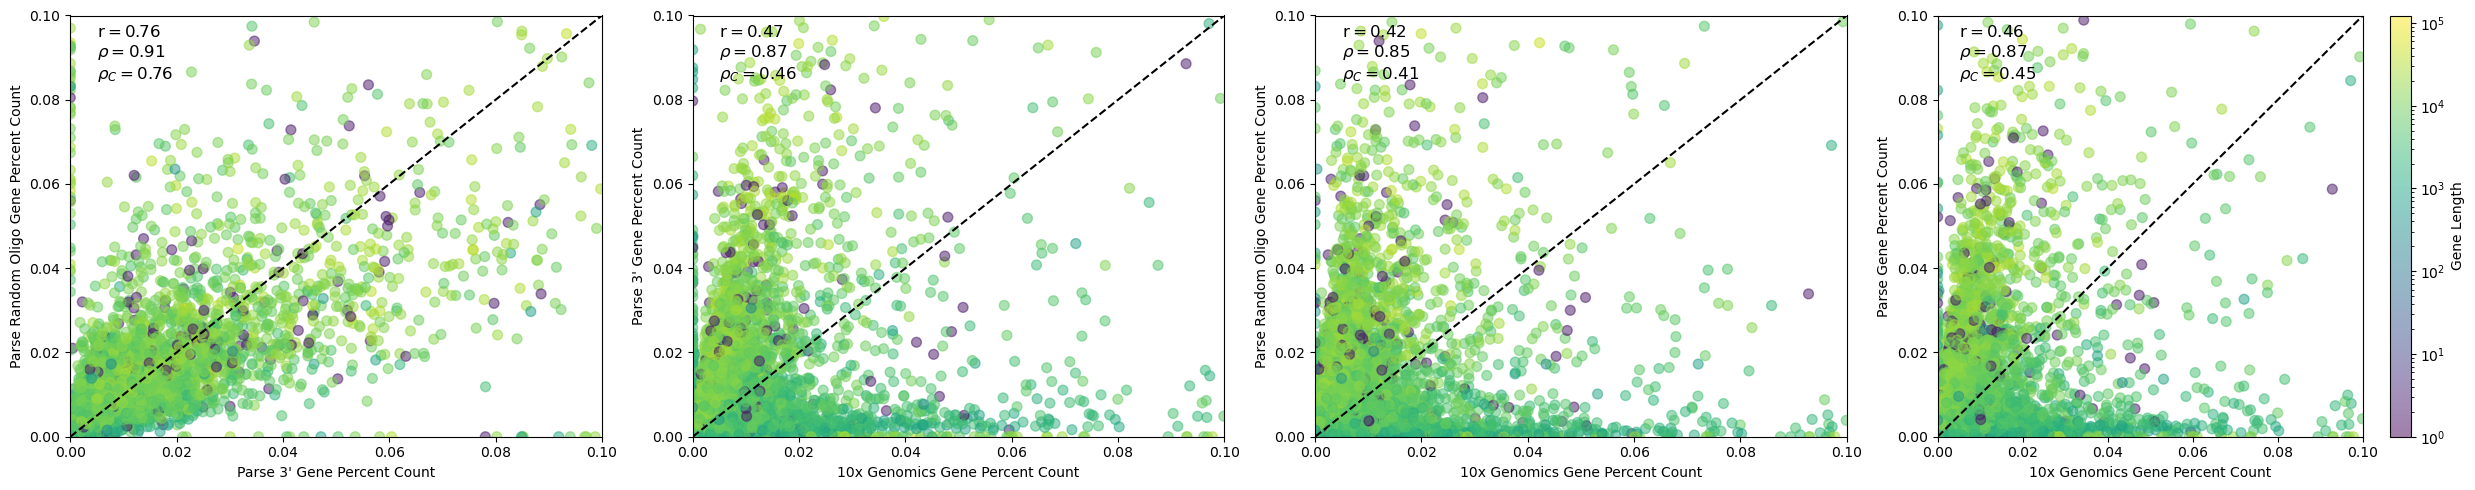

In [113]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    df['gene_length'] = df['gene_length']+1
    c_values.extend(df['gene_length'].tolist())
norm = LogNorm(1, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gene_length', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Gene Length")

plt.tight_layout()
plt.show()

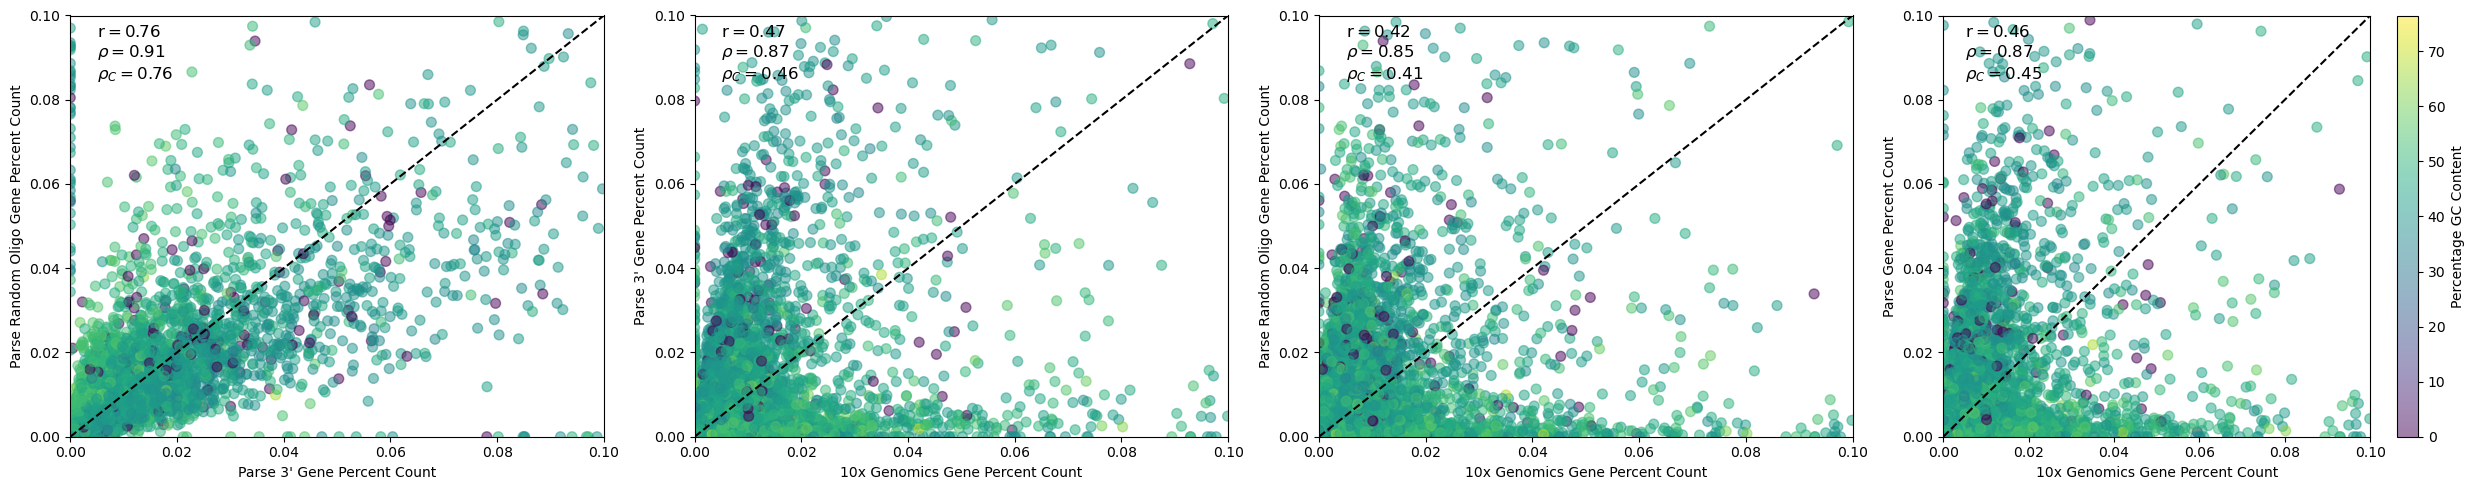

In [114]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

c_values = []
for df in compare_dfs:
    c_values.extend(df['gc_content'].tolist())
norm = Normalize(0, max(c_values))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    plot = scatter_genes(ax, 
                         df, 
                         pair[0],
                         pair[1], 
                         'gc_content', 
                         xlim=lim, 
                         ylim=lim, 
                         norm=norm)
    show_correlation(ax,df)

fig.colorbar(plot, label = "Percentage GC Content")

plt.tight_layout()
plt.show()

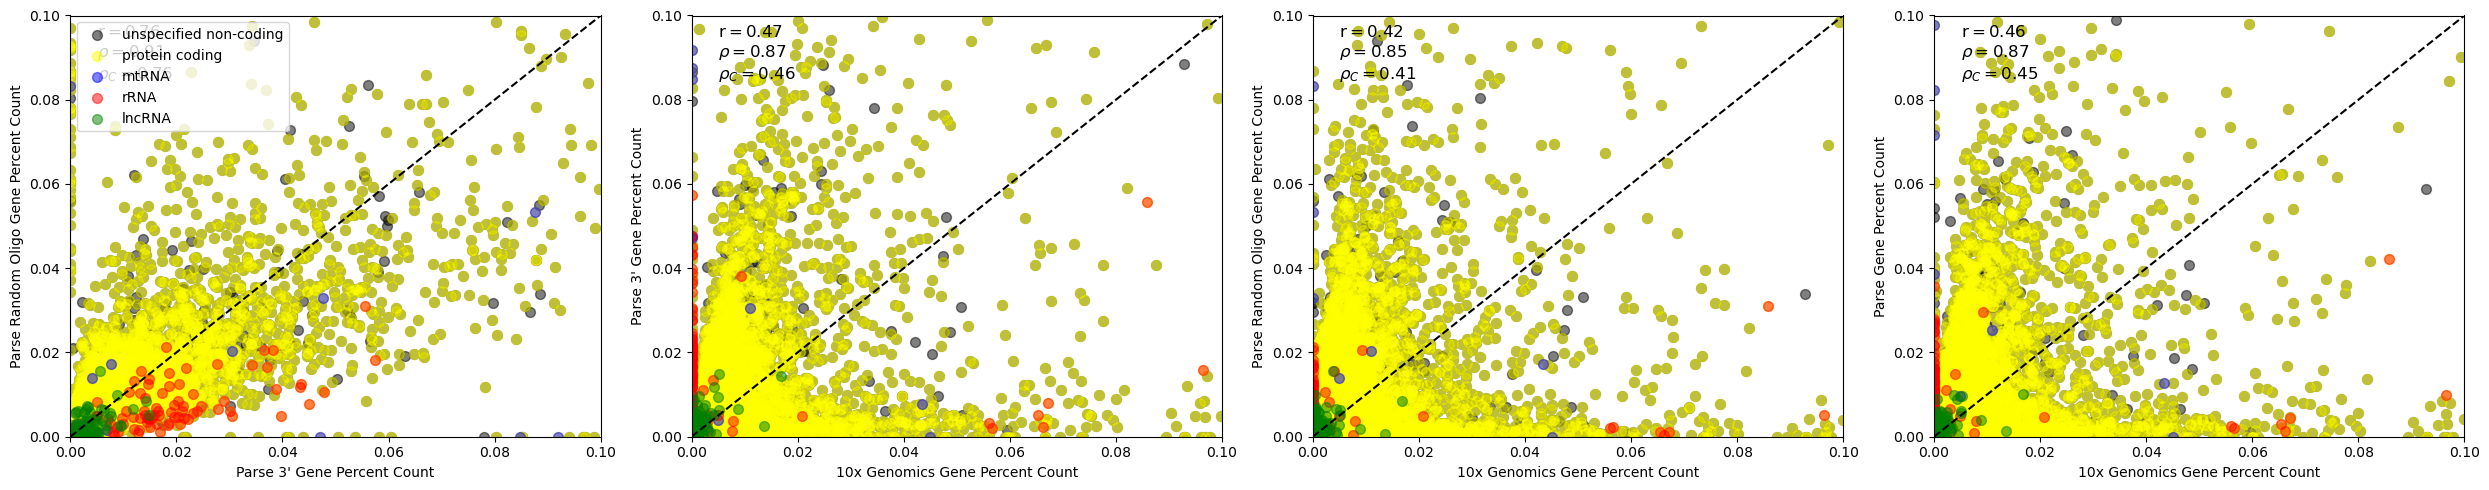

In [115]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

for ax, df , pair in zip(axs, compare_dfs,comparisons):
    cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                      pair[0], pair[1],'black', 
                      label = 'unspecified non-coding', xlim=lim, ylim=lim)
    for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                            ['yellow', 'blue', 'red', 'green'],
                            ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
        cat_scatter_genes(ax, df[df[col]], pair[0], pair[1], 
                          c, label=label,xlim=lim, ylim=lim)

    show_correlation(ax,df)
    
axs[0].legend()

plt.tight_layout()
plt.show()

In [116]:
for shared_data, string in zip(compare_dfs, 
                               ("polyT vs randO", "polyT vs 10X", "10X vs randO", "Parse vs 10X")):
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance for", string, ":",  shared_data['gene_names'][:10].tolist())

Top 10 outliers based on Cook's distance for polyT vs randO : ['Taf1d', 'Myh9', 'Lars2', 'Cd8a', 'mt-Cytb', 'Hnrnph1', 'Eif4g2', 'mt-Co3', 'Ccnd3', 'Gm43305']
Top 10 outliers based on Cook's distance for polyT vs 10X : ['Son', 'Hnrnpa2b1', 'Atp5j', 'Hnrnpa3', 'Ndufa4', 'Bcl11b', 'Arpp21', 'Snrpg', 'Cox6c', 'Myl6']
Top 10 outliers based on Cook's distance for 10X vs randO : ['Son', 'Hnrnpa2b1', 'Atp5j', 'Hnrnpa3', 'Ndufa4', 'Cox7c', 'Snrpg', 'Cox6c', 'Bcl11b', 'Arpp21']
Top 10 outliers based on Cook's distance for Parse vs 10X : ['Son', 'Hnrnpa2b1', 'Atp5j', 'Hnrnpa3', 'Ndufa4', 'Bcl11b', 'Arpp21', 'Snrpg', 'Cox6c', 'Cox7c']


In [117]:
for data in datasets:
    name = data.uns['title']
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index.tolist()
    print("Top 10 genes in", name, "data:")
    print(top_genes)
    print()

Top 10 genes in 10x Genomics data:
['Malat1', 'mt-Co3', 'mt-Atp6', 'Tmsb4x', 'mt-Co2', 'Rps8', 'Tpt1', 'Rpl13', 'Ptma', 'Trbc2']

Top 10 genes in Parse 3' data:
['Malat1', 'Satb1', 'Prrc2c', 'Ptprc', 'Ptma', 'Rbm25', 'Atrx', 'Xist', 'Hnrnpa2b1', 'Hmgb1']

Top 10 genes in Parse Random Oligo data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Rag1', 'Ccnb1ip1', 'Prrc2c', 'Arpp21', 'Xist', 'mt-Co1']

Top 10 genes in Parse data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Prrc2c', 'Ptma', 'Xist', 'Rbm25', 'Atrx', 'Rag1']



In [118]:
with open("t2g.txt") as t2g:
    gene_id = []
    for line in t2g:
        gene_id.append(line.strip().split()[1])
gene_id = list(set(gene_id))
df_genes = pd.DataFrame({'gene_id': gene_id})

In [119]:
dict = {}
cell_thresh = 10
contents = pd.DataFrame()

for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    mask = (df_genes['gene_id'].isin(var['gene_id'])).tolist()
    contents[str(data.uns['name'])] = mask

upset = Upset.generate_plot(contents)
contents['gene_ids'] = df_genes['gene_id']
upset.show()

In [120]:
genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_PO = contents['gene_ids'][~contents['10x']& 
                                ~contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_PO = genes_PO.tolist()

genes_XPO = contents['gene_ids'][contents['10x']& 
                                ~contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_XPO = genes_XPO.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

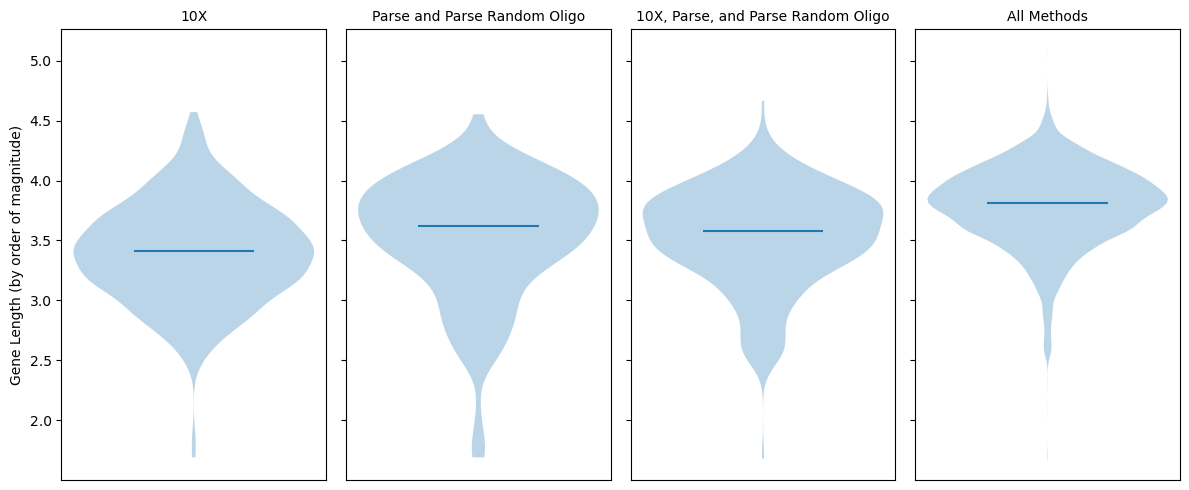

In [121]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_lengths['gene_length'][gene_lengths['gene_id'].isin(data)]
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

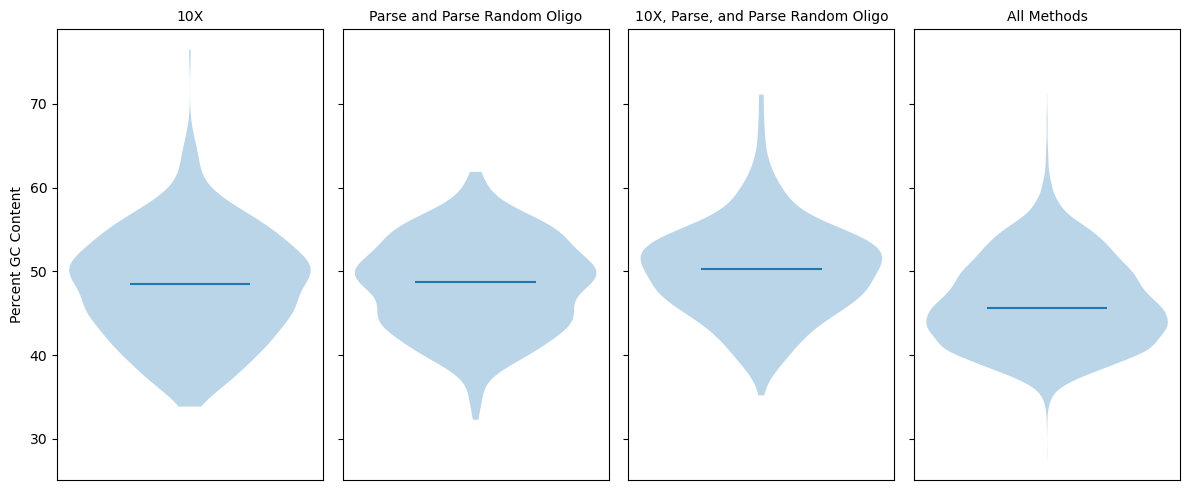

In [122]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gc_content['gc_content'][gc_content['gene_id'].isin(data)]
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

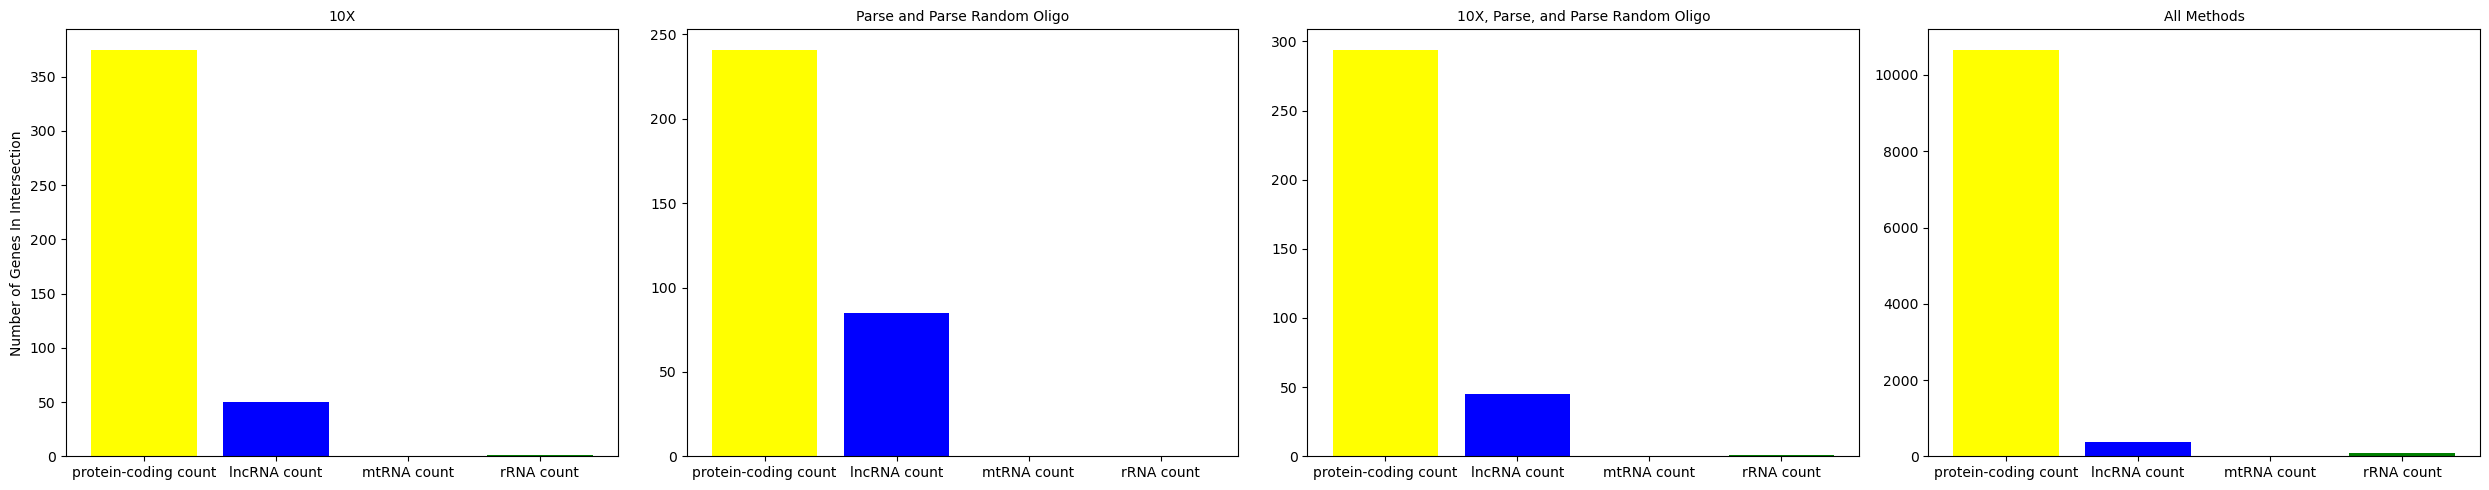

In [123]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_df[col][gene_df['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)

axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()

In [124]:
dict = {}
cell_thresh = 10

for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    top_data = var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (df_genes['gene_id'].isin(top_data['gene_id'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
contents['gene_ids'] = df_genes['gene_id']
upset.show()

In [125]:
genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_POT = contents['gene_ids'][~contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_POT = genes_POT.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

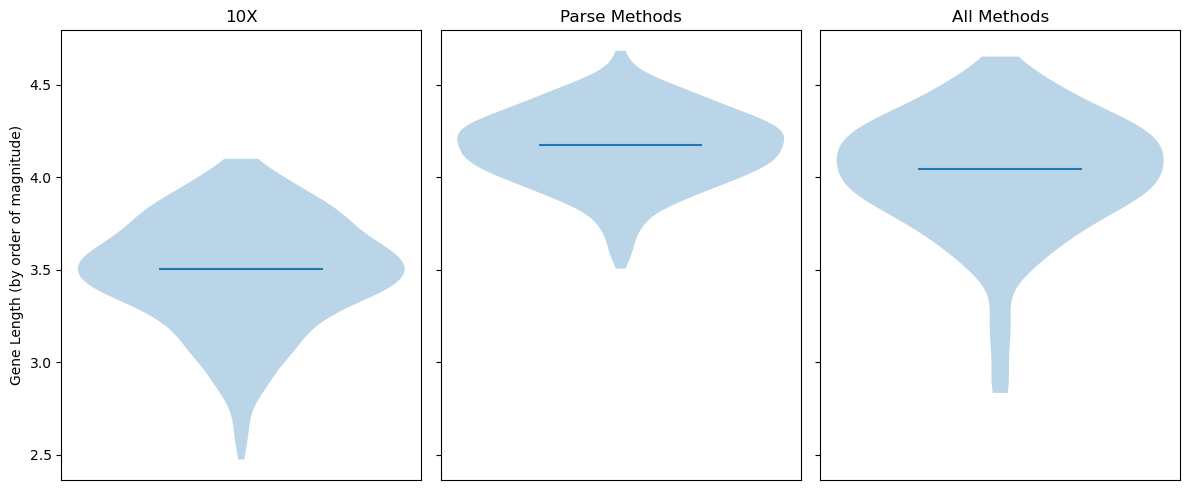

In [126]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_lengths['gene_length'][gene_lengths['gene_id'].isin(data)]
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

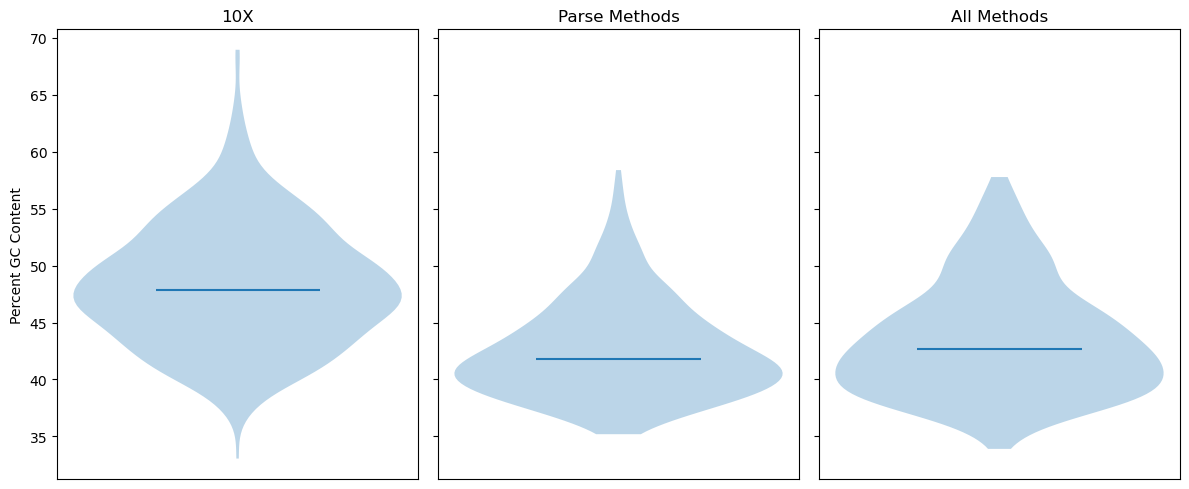

In [127]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gc_content['gc_content'][gc_content['gene_id'].isin(data)]
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

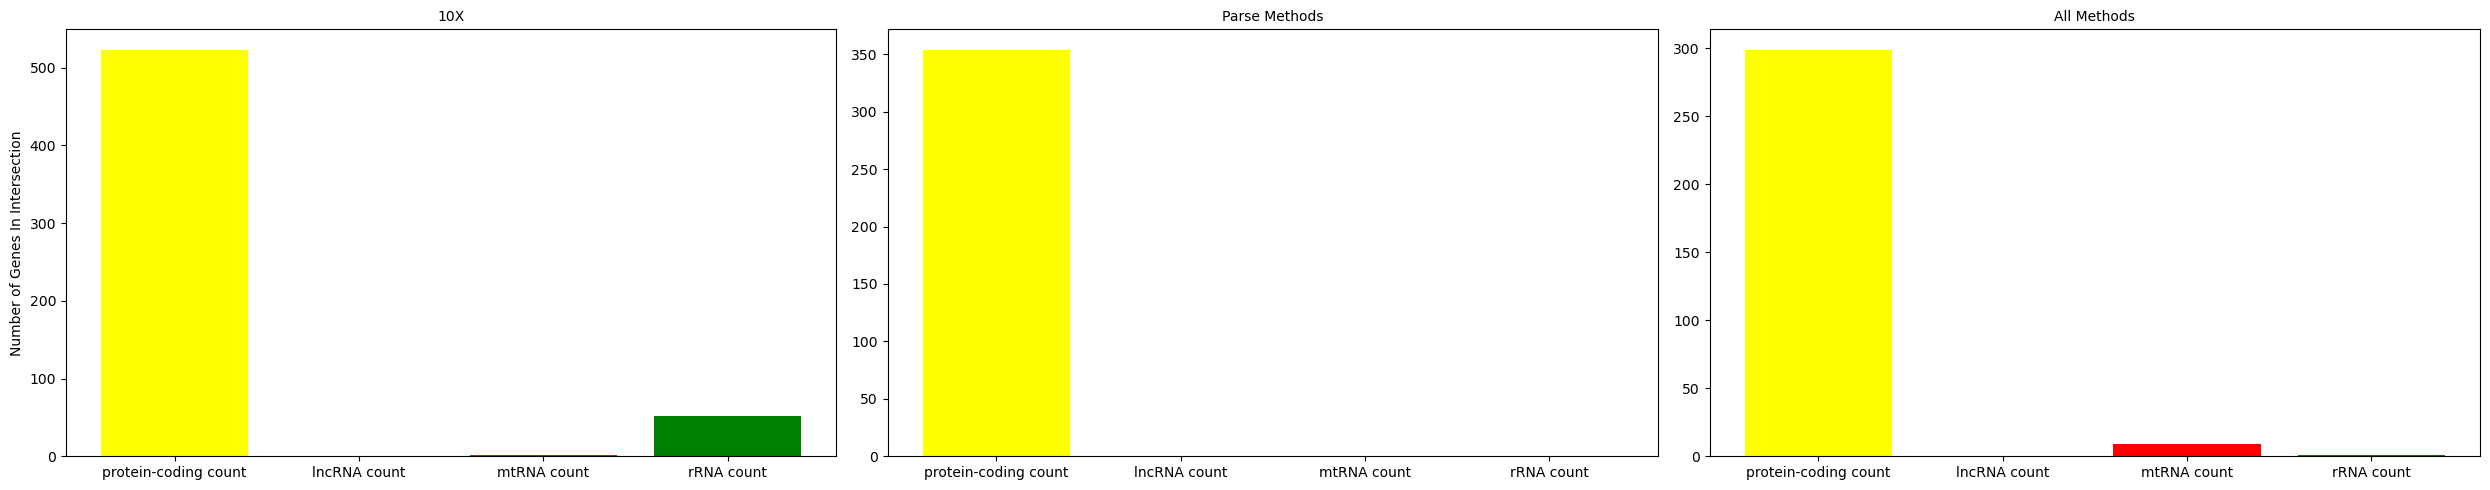

In [128]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_df[col][gene_df['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)
axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()